Inspired by https://arxiv.org/abs/2401.13411 try an autoencoder based approach to generating the spectra

In [1]:
import platform
from pathlib import Path
from copy import deepcopy
import functools

import numpy as np

from astropy import units as u
from astropy import constants as cnst
from astropy.io import fits
from astropy import modeling

from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cuda device with dtype torch.float32


See [resampling_tensors.ipynb](resampling_tensors.ipynb) for deriving the tensors from the spectra.  Note it doesn't perfectly match all the spectra because we are skipping the interpolated ones.

In [3]:
if device == 'cpu':
    if platform.node()=='falcata':
        torch.set_num_threads(12)  # COMPUTER DEPENDENT!
    else:
        print('unrecognized machine, using default')

# Data loading and prep

See [bb_fit_experiments.ipynb](bb_fit_experiments.ipynb) to see justification for the bb-based normalization scheme

In [4]:
alltensorpaths = list(Path('resampled_tensors').glob('*_2k.pt'))
len(alltensorpaths)

7508

In [5]:
headers = []
wls = []
fluxes = []

for pth in tqdm(alltensorpaths):
    data = torch.load(pth, weights_only=True)
    headers.append(data['header'])
    wls.append(data['wl'])
    fluxes.append(data['flux'])

fluxes = torch.stack(fluxes)

  0%|          | 0/7508 [00:00<?, ?it/s]

In [6]:
assert torch.all(torch.stack(wls)==wls[0])
wl = wls[0]
del wls

In [7]:
teff = torch.tensor([h['PHXTEFF'] for h in headers])
logg = torch.tensor([h['PHXLOGG'] for h in headers])
feh = torch.tensor([h['PHXM_H'] for h in headers])

infeatures = torch.stack([teff,logg,feh], dim=1)

In [8]:
wla = wl * u.angstrom
fluxwunit = fluxes.numpy() << u.Unit(headers[0]['BUNIT'])

In [9]:
residuals = []
for teffi, flux in zip(teff, fluxwunit):
    bb = modeling.models.BlackBody(temperature=teffi*u.K, scale=1*flux.unit/u.sr)
    bbflux = bb(wl)*u.sr

    rflux = (flux - flux.mean())/flux.std()
    rbbflux = (bbflux - bbflux.mean())/bbflux.std()
    residuals.append(torch.Tensor((rflux - rbbflux).value))
residuals = torch.stack(residuals)

In [10]:
xy_res_ds = TensorDataset(infeatures.to(device, tensor_dtype), residuals.to(device, tensor_dtype))
next(iter(xy_res_ds))

(tensor([2.3000e+03, 0.0000e+00, 5.0000e-01], device='cuda:0'),
 tensor([0.4737, 0.4403, 0.4914,  ..., 1.1917, 1.0697, 1.1308], device='cuda:0'))

# Helper Functions

In [11]:
def train_validation(model, dataset, nepochs, batch_size, lr, ttsplit=[.3, .7], inner_validation=False, weight_decay=0, eps=1e-8, loss_fcn=nn.MSELoss(), scheduler_fcn=None):
    split_data = random_split(dataset, ttsplit, torch.Generator().manual_seed(42))
    valid_data, train_data = split_data
    valid_X, valid_Y = valid_data.dataset.tensors[:2]
    
    valid_losses = []
    valid_niters = []

    train_losses = []
    train_niters = []

    lrs = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, eps=eps)
    if scheduler_fcn is not None:
        scheduler = scheduler_fcn(optimizer)
    
    niters = 0

    def validation_fcn():
        model.eval()
        with torch.no_grad():
            pred = model(valid_X)
            valid_loss = loss_fcn(pred,valid_Y).item()
            valid_losses.append(valid_loss)
            valid_niters.append(niters)
        return valid_loss
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for data in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            X, Y = data[:2]
            optimizer.zero_grad()
            
            pred = model(X)
            loss = loss_fcn(pred, Y)
            
            loss.backward()
            optimizer.step()
    
            niters += X.shape[0]
            
            train_losses.append(loss.item())
            train_niters.append(niters)

            if inner_validation:
                valid_loss = validation_fcn()
                
                if scheduler_fcn is not None:
                    scheduler.step()
                    lrs.append(scheduler.get_last_lr())
            
        if not inner_validation:
            if scheduler_fcn is not None:
                scheduler.step()
                lrs.append(scheduler.get_last_lr())
                
            valid_loss = validation_fcn()
                
        if scheduler_fcn is None:
            pbar.set_description(f'valid loss={valid_loss:.3e}')
        else:
            pbar.set_description(f'valid loss={valid_loss:.3e}, lr={lrs[-1][0]:.3e}')
            
    if scheduler_fcn is None:
        return (valid_niters, valid_losses), (train_niters, train_losses), split_data
    else:
        return (valid_niters, valid_losses), (train_niters, train_losses), lrs, split_data

# Autoencoder 

A simple MLP-based autoencoder, no conv layers at first 

In [12]:
class Encoder(nn.Module):
    def __init__(self, npix, nneurons, activation_cls):
        super().__init__()

        prev_layern = npix
        stack = []
        for nneur in nneurons:
            stack.append(nn.Linear(prev_layern, nneur))
            stack.append(activation_cls())
            prev_layern = nneur
            
        self.stack = nn.Sequential(*stack)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def npix(self):
        return self.stack[0].num_features
        
    @property
    def latent_size(self):
        return self.stack[-1].num_features
        
    def forward(self, x):
        return self.stack(x)

class Decoder(nn.Module):
    def __init__(self, npix, nneurons, activation_cls):
        super().__init__()

        prev_layern = nneurons[0]
        stack = []
        for nneur in nneurons[1:]:
            stack.append(nn.Linear(prev_layern, nneur))
            stack.append(activation_cls())
            prev_layern = nneur
        stack.append(nn.Linear(prev_layern, npix))
            
        self.stack = nn.Sequential(*stack)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def npix(self):
        return self.stack[-1].num_features
        
    @property
    def latent_size(self):
        return self.stack[0].num_features
        
    def forward(self, x):
        return self.stack(x)
        
class Autoencoder(nn.Module):
    def __init__(self, npix, nneurons, activation_cls=nn.GELU):
        super().__init__()

        self.encoder = Encoder(npix, nneurons, activation_cls)
        self.decoder = Decoder(npix, nneurons[::-1], activation_cls)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def npix(self):
        return self.encoder.stack[0].num_features
        
    @property
    def latent_size(self):
        return self.encoder.stack[-1].num_features
        
    def forward(self, x):
        x = torch.atleast_2d(x)
        latent = self.encoder(x)
        return self.decoder(latent)

aec = Autoencoder(fluxes.shape[-1], [100, 10])
aec

Autoencoder(
  (encoder): Encoder(
    (stack): Sequential(
      (0): Linear(in_features=2048, out_features=100, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=100, out_features=10, bias=True)
      (3): GELU(approximate='none')
    )
  )
  (decoder): Decoder(
    (stack): Sequential(
      (0): Linear(in_features=10, out_features=100, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=100, out_features=2048, bias=True)
    )
  )
)

First try it with the residual from bb dataset:

In [13]:
aec_res_ds = TensorDataset(xy_res_ds.tensors[1], xy_res_ds.tensors[1])  # X and Y are same for aec
next(iter(aec_res_ds))

(tensor([0.4737, 0.4403, 0.4914,  ..., 1.1917, 1.0697, 1.1308], device='cuda:0'),
 tensor([0.4737, 0.4403, 0.4914,  ..., 1.1917, 1.0697, 1.1308], device='cuda:0'))

  0%|          | 0/2500 [00:00<?, ?it/s]

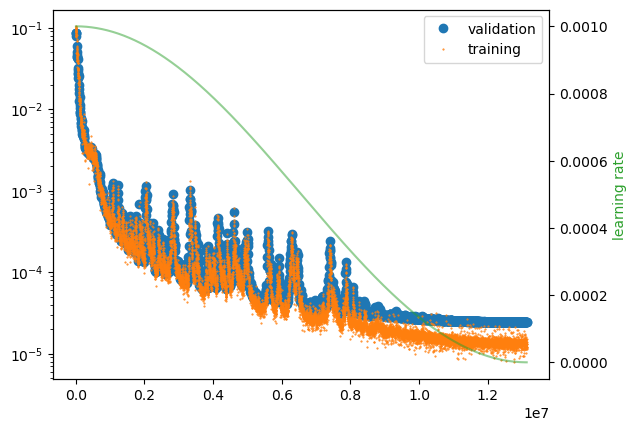

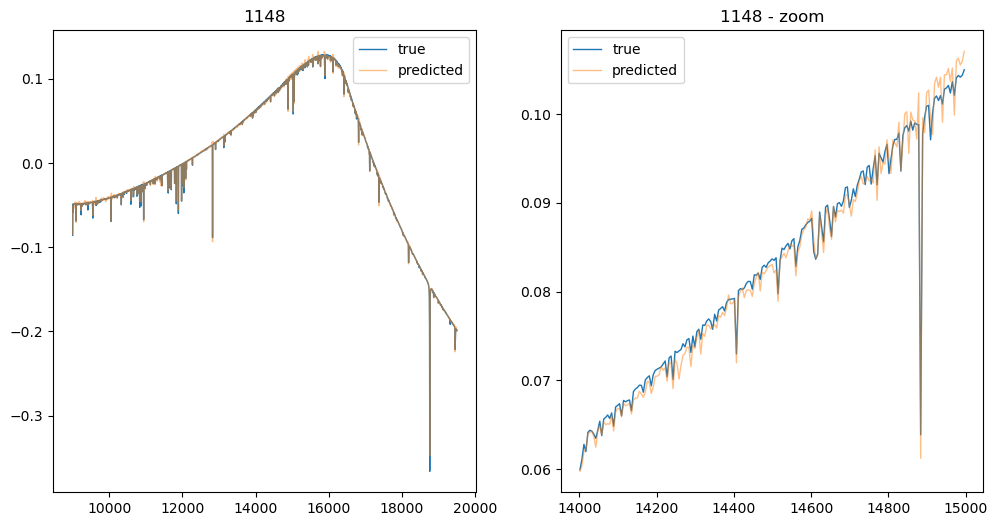

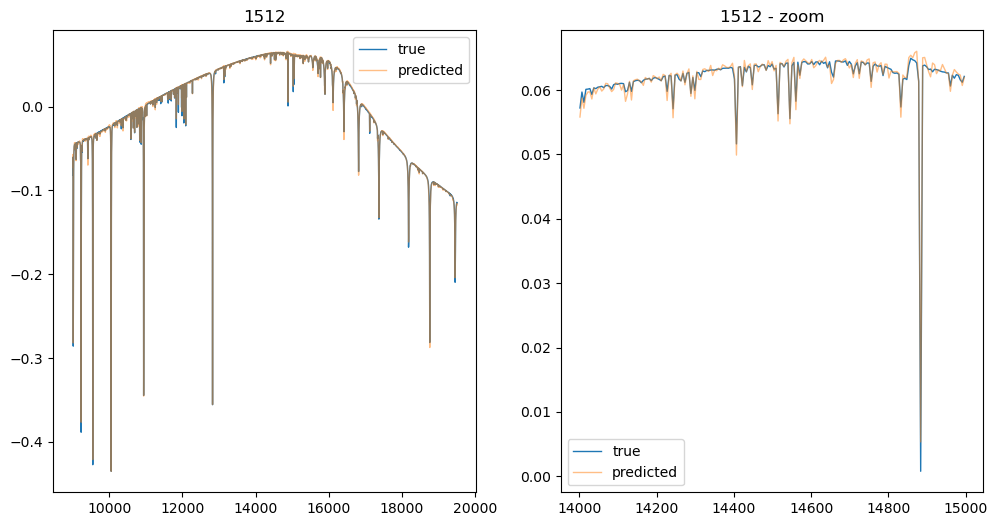

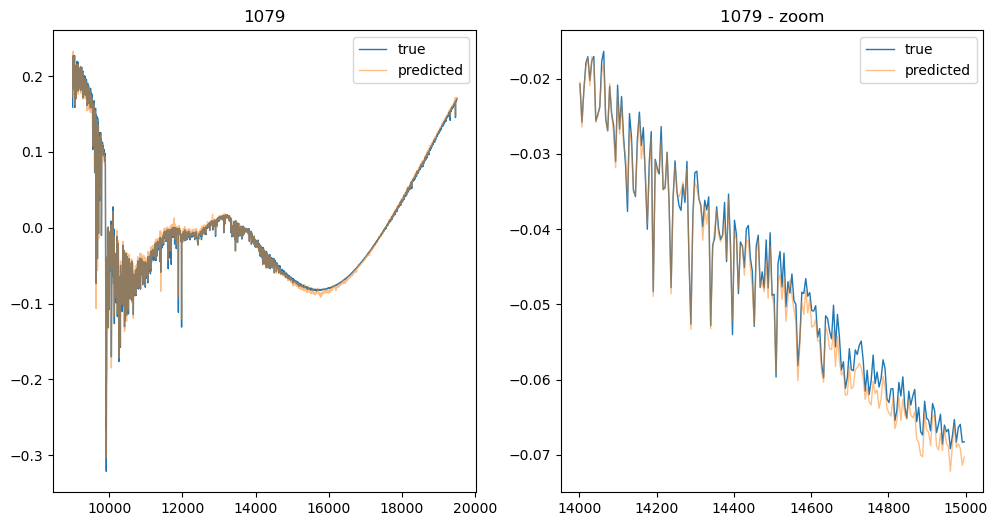

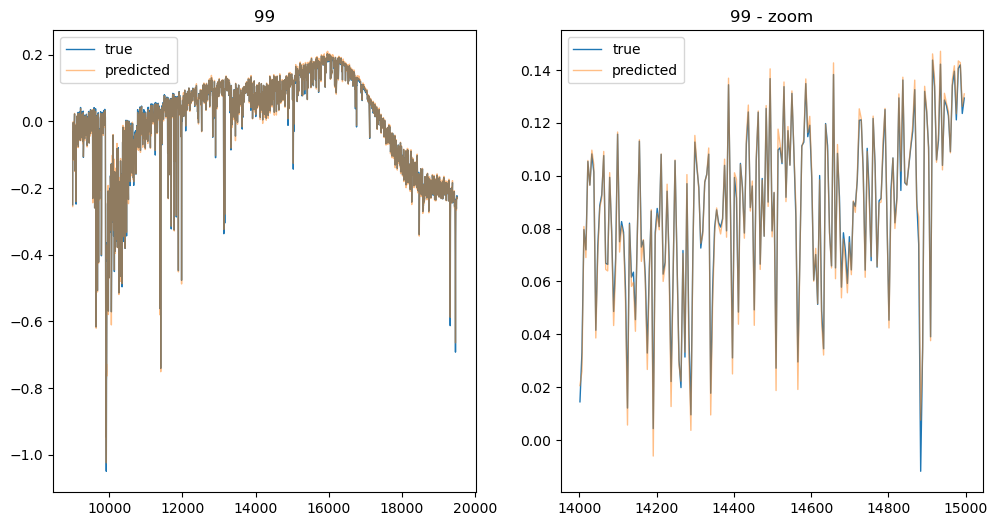

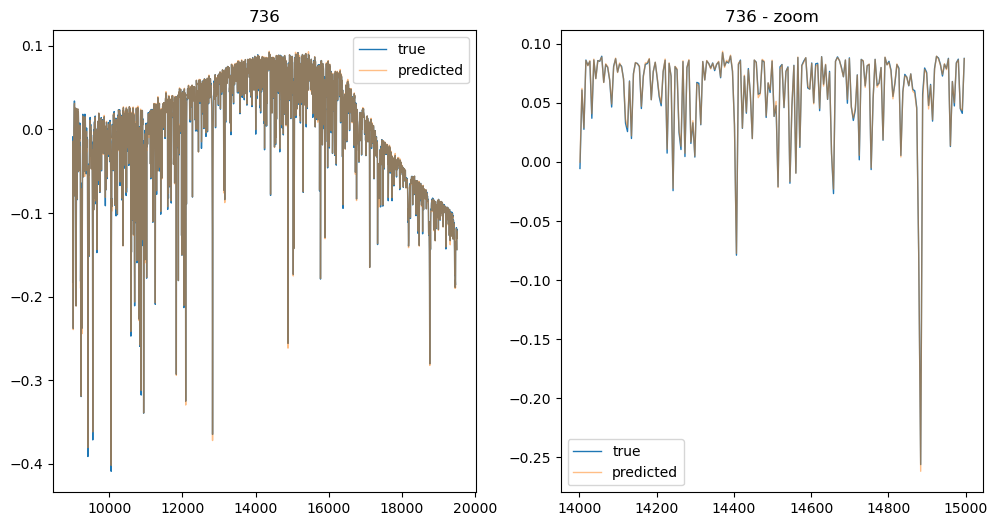

In [22]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 16]).to(device, tensor_dtype)

nepochs = 2500
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingLR, T_max=nepochs)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=aec_res_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=1e-3, 
                                            weight_decay=1e-5, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

  0%|          | 0/4800 [00:00<?, ?it/s]

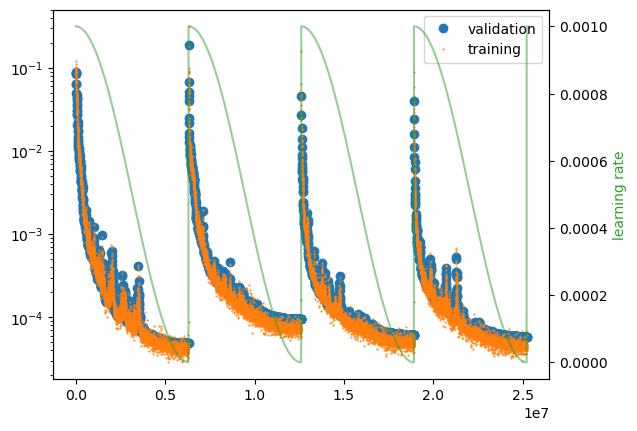

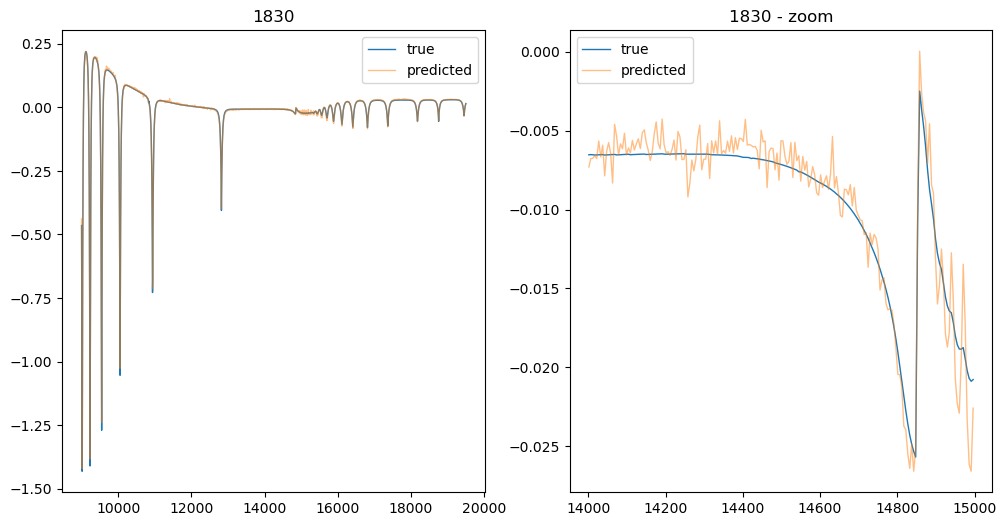

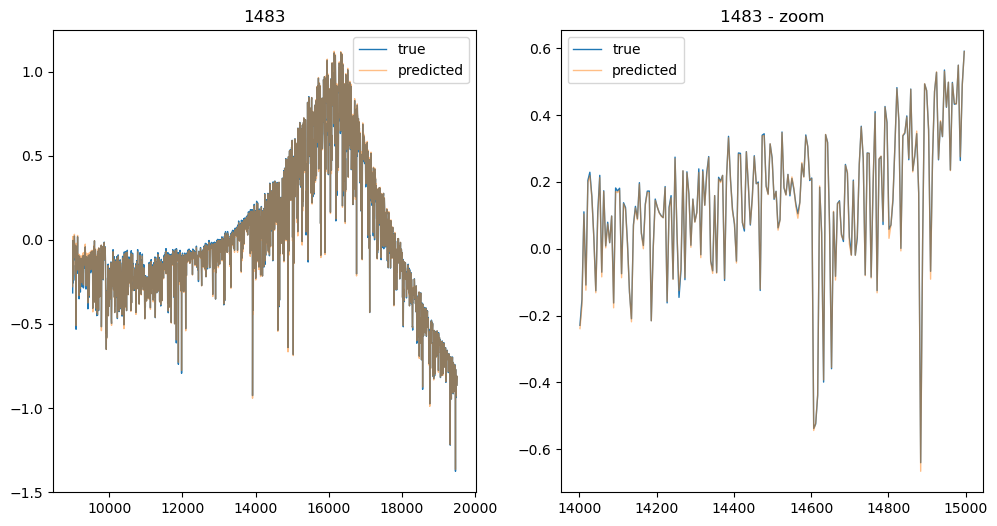

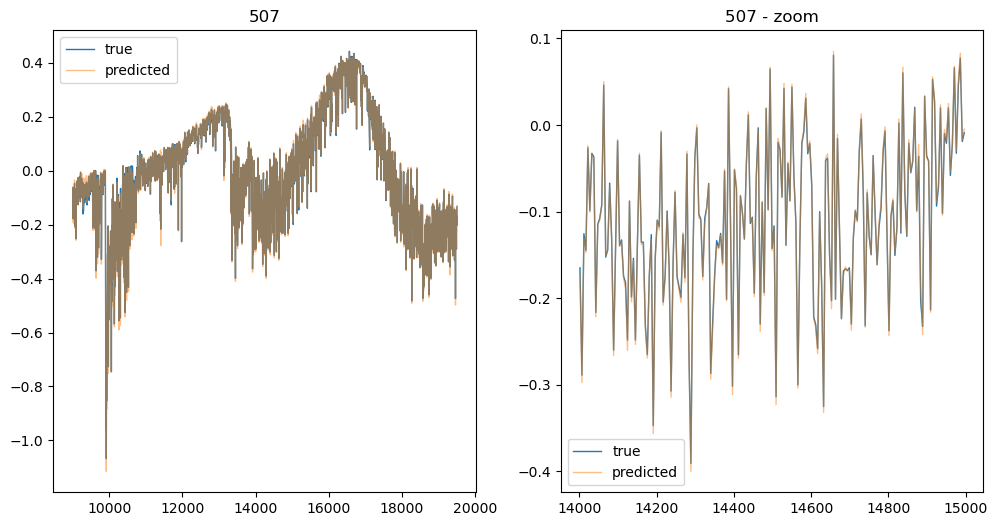

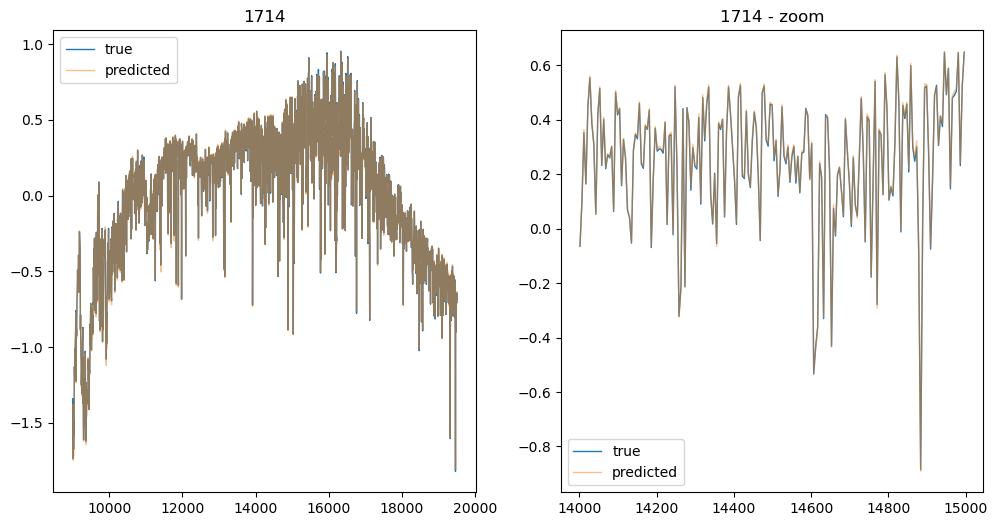

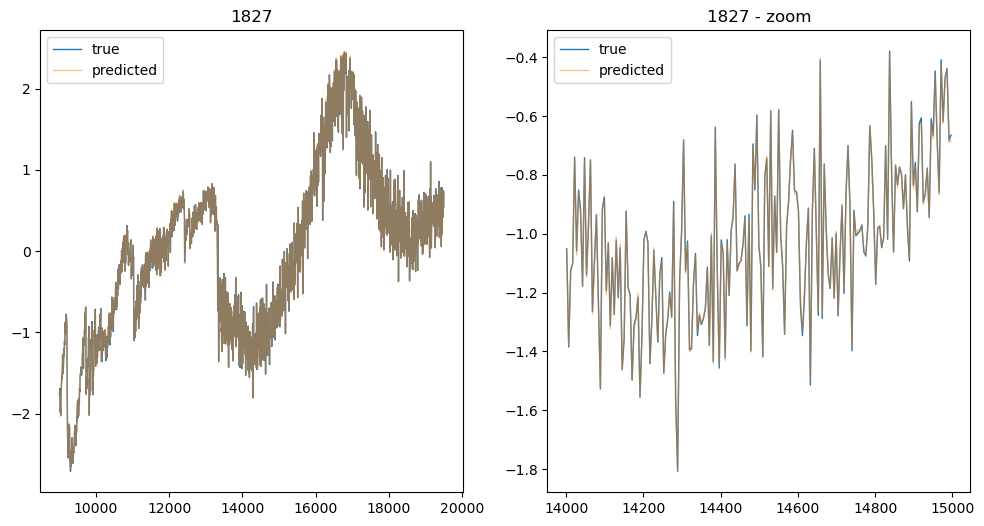

In [30]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 16]).to(device, tensor_dtype)

nperrestart = 1200
nrestarts = 4
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=aec_res_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=1e-3, 
                                            weight_decay=1e-3, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

  0%|          | 0/7200 [00:00<?, ?it/s]

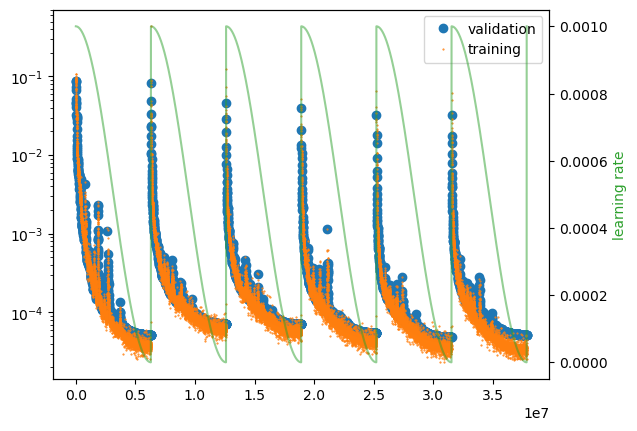

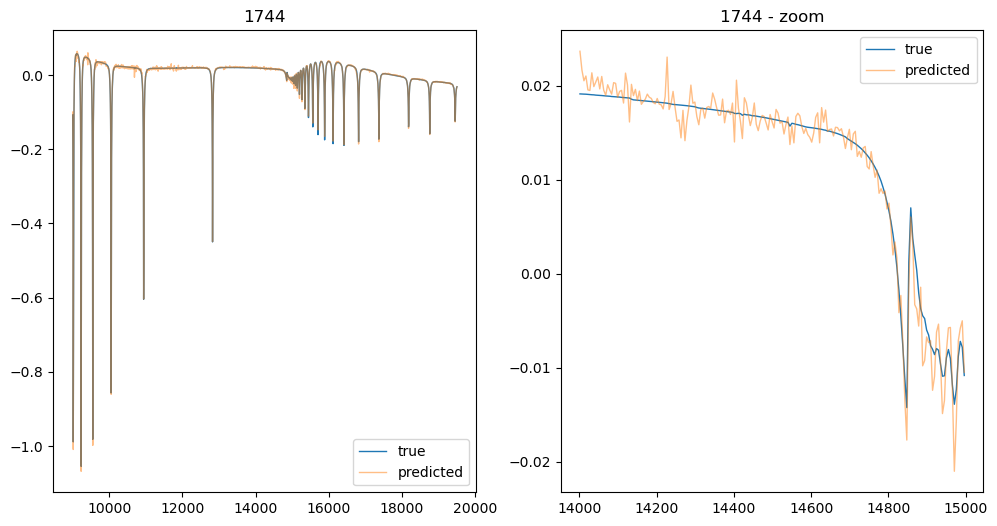

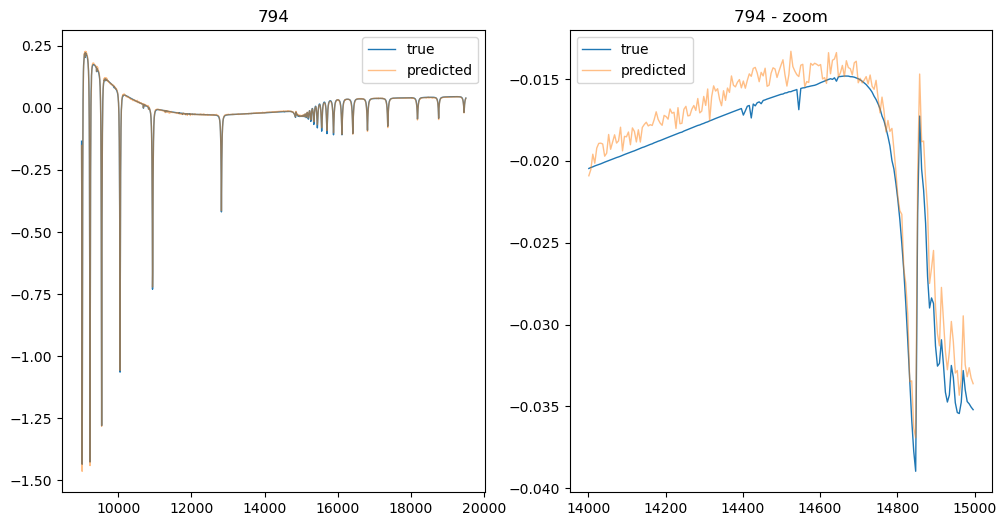

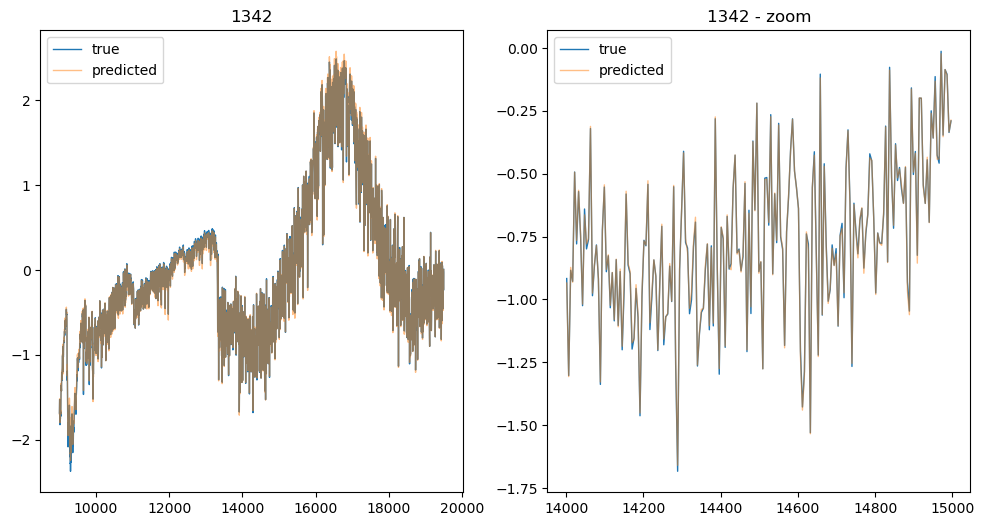

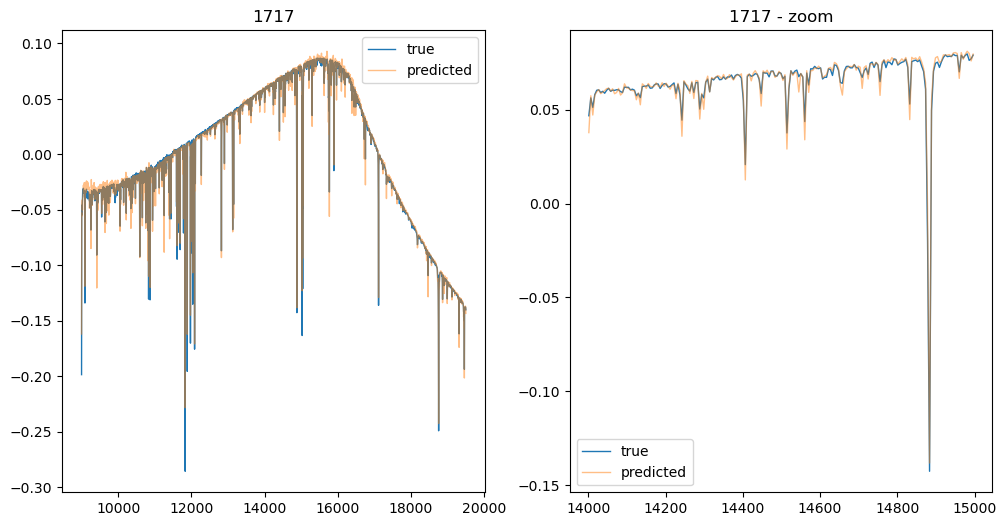

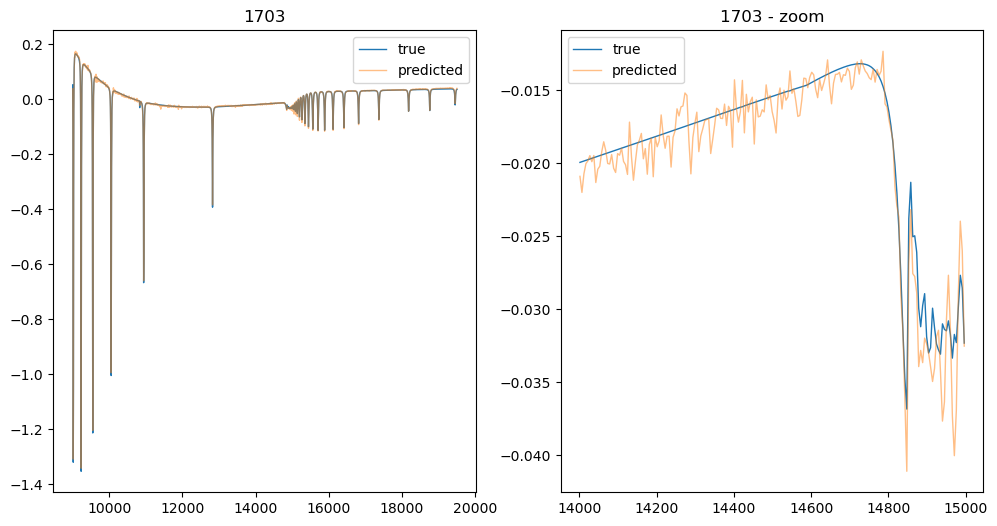

In [25]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 16]).to(device, tensor_dtype)

nperrestart = 1200
nrestarts = 6
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=aec_res_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=1e-3, 
                                            weight_decay=1e-5, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

  0%|          | 0/4800 [00:00<?, ?it/s]

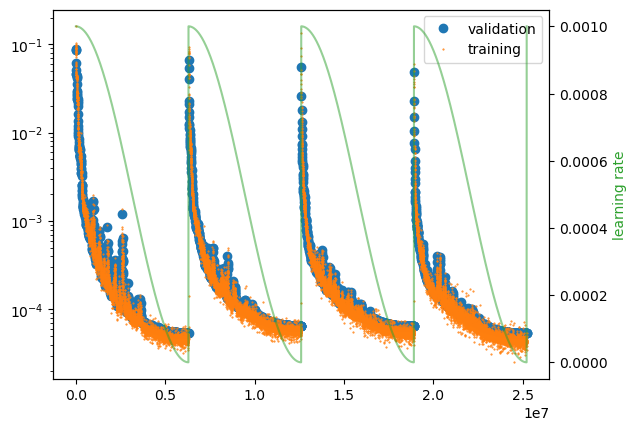

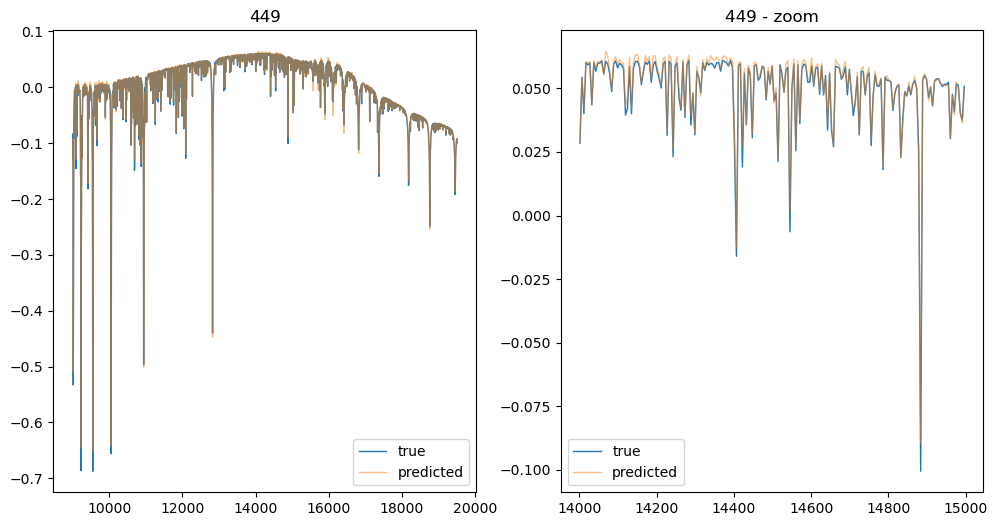

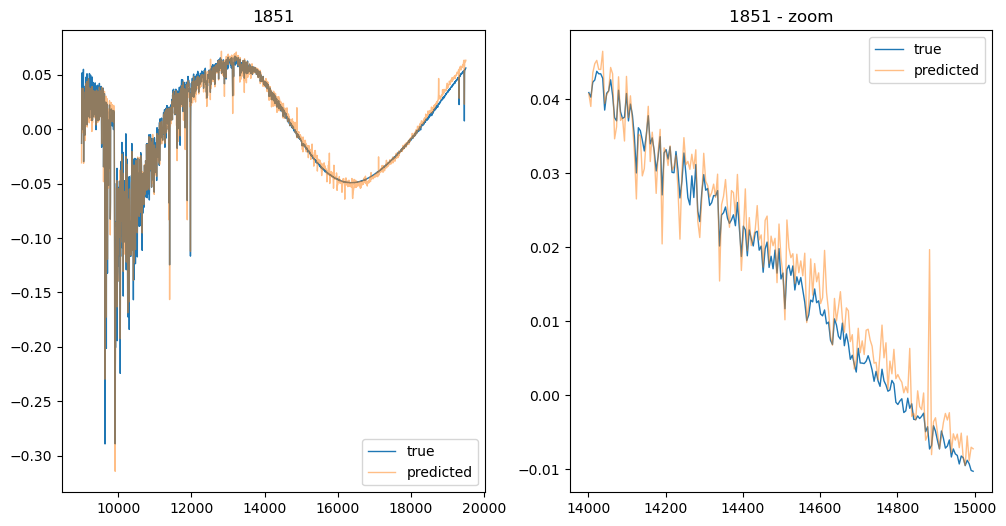

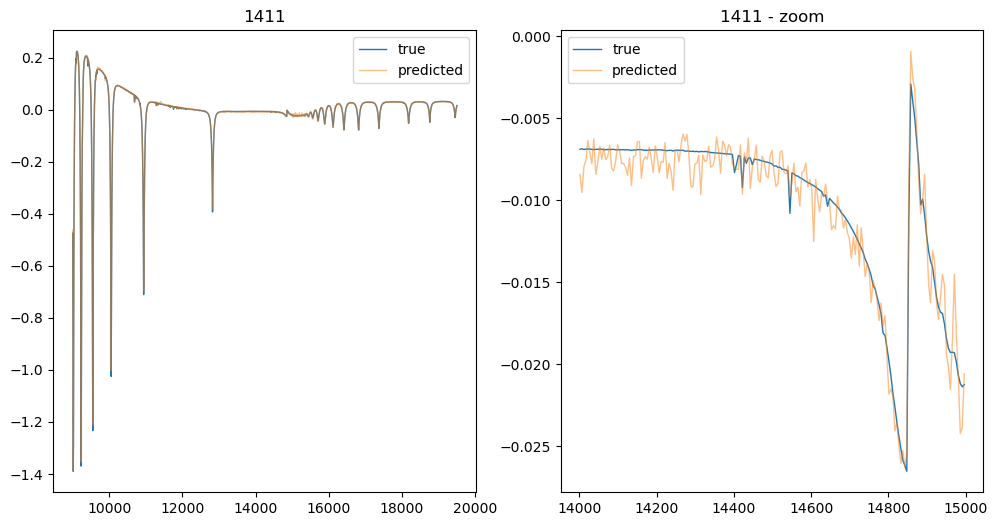

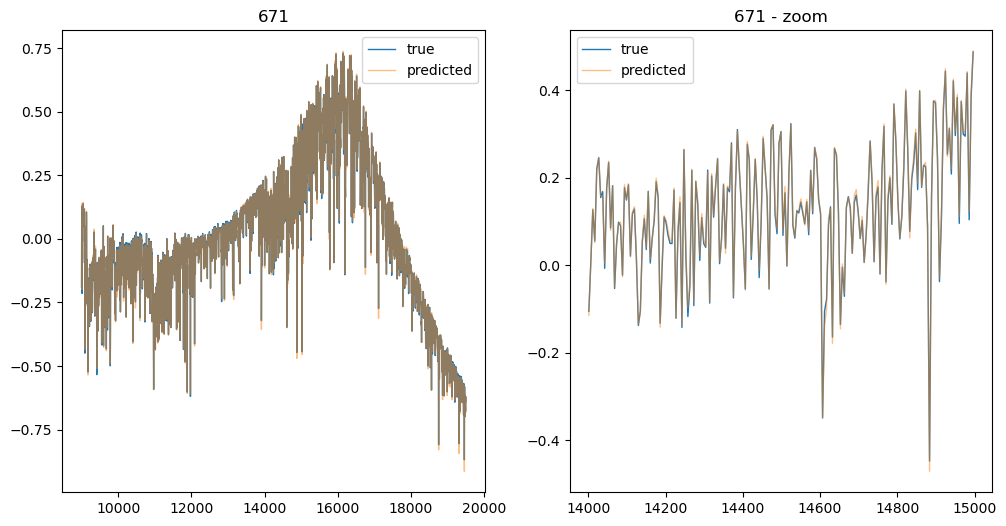

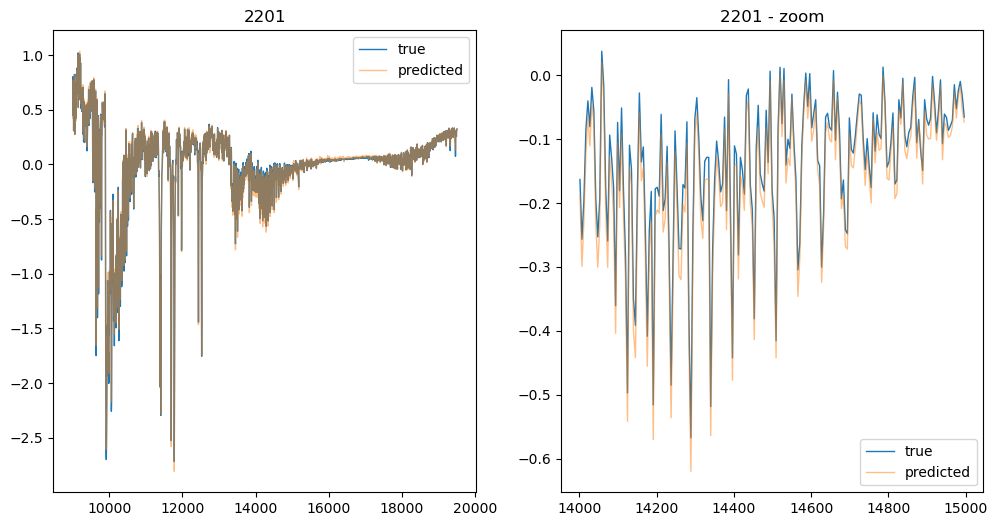

In [27]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 16]).to(device, tensor_dtype)

nperrestart = 1200
nrestarts = 4
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=aec_res_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=1e-3, 
                                            weight_decay=0, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

  0%|          | 0/7200 [00:00<?, ?it/s]

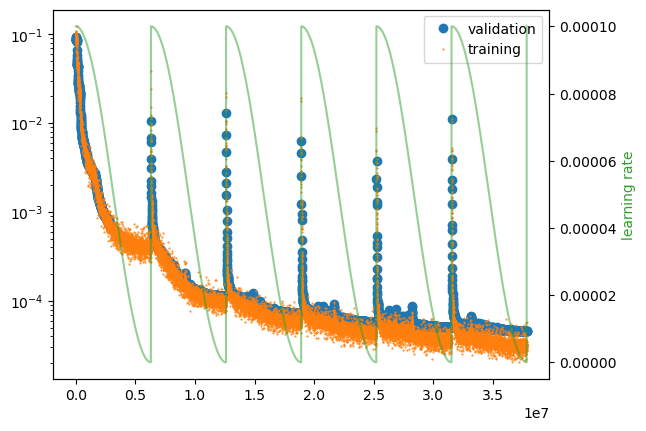

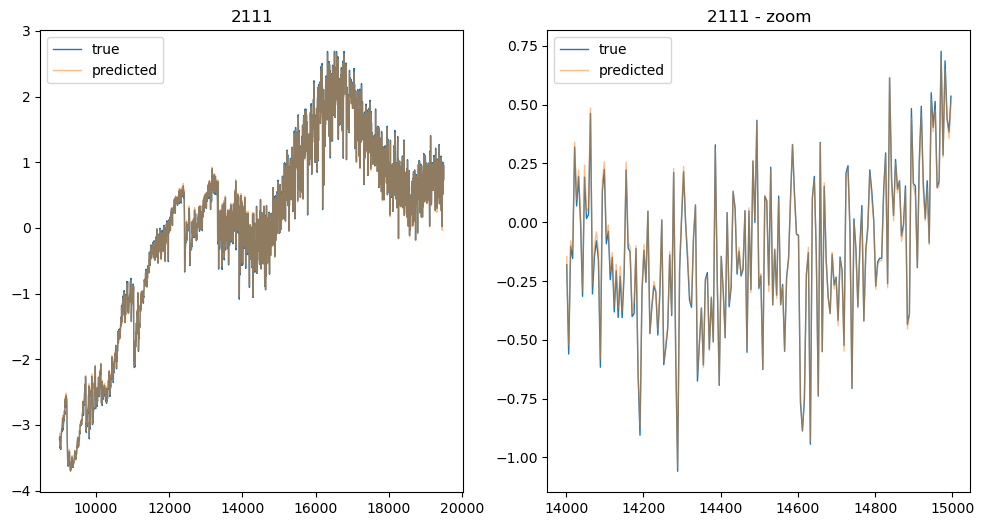

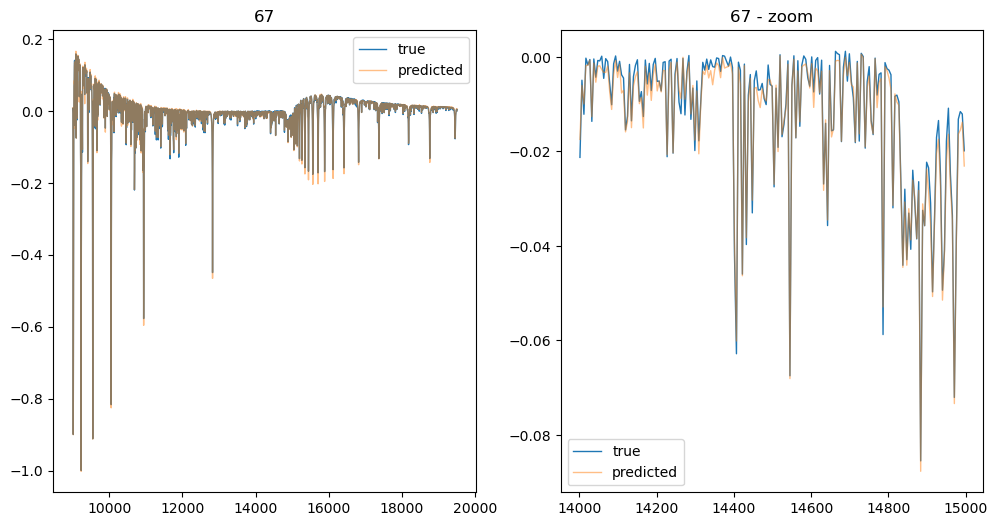

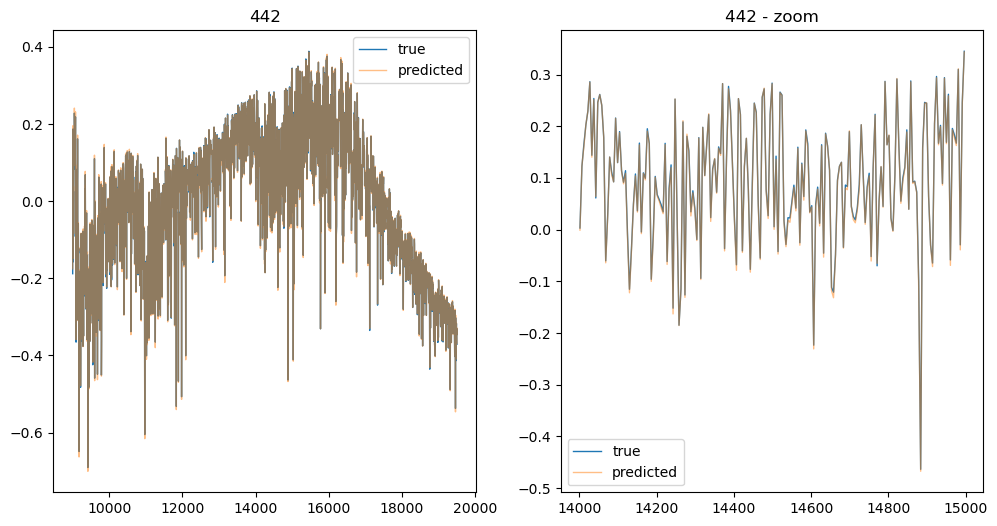

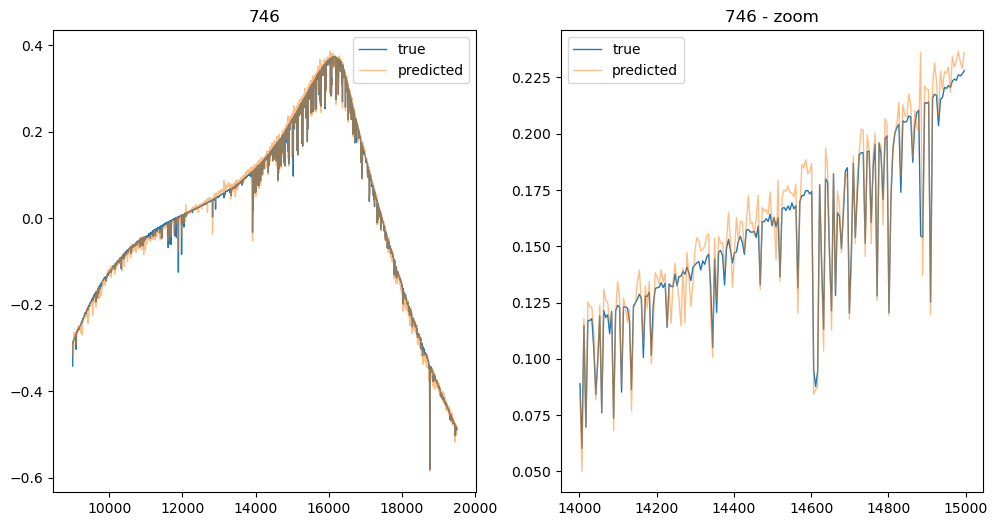

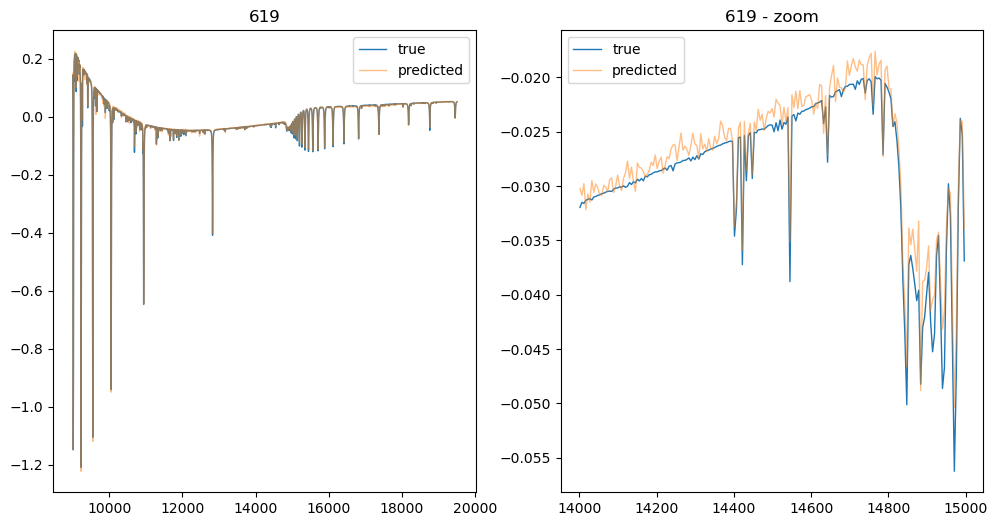

In [32]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 16]).to(device, tensor_dtype)

nperrestart = 1200
nrestarts = 6
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=aec_res_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=1e-4, 
                                            weight_decay=1e-5, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

  0%|          | 0/9000 [00:00<?, ?it/s]

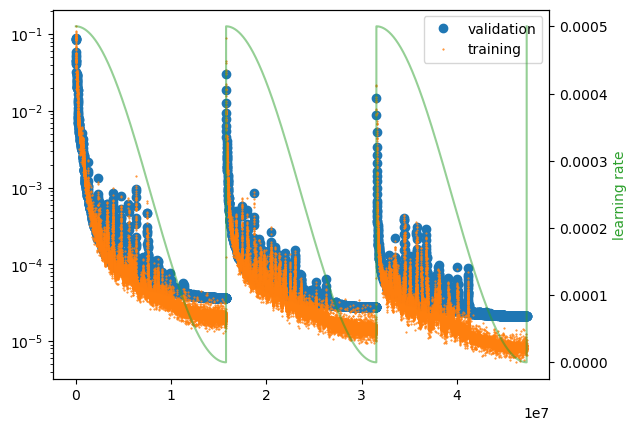

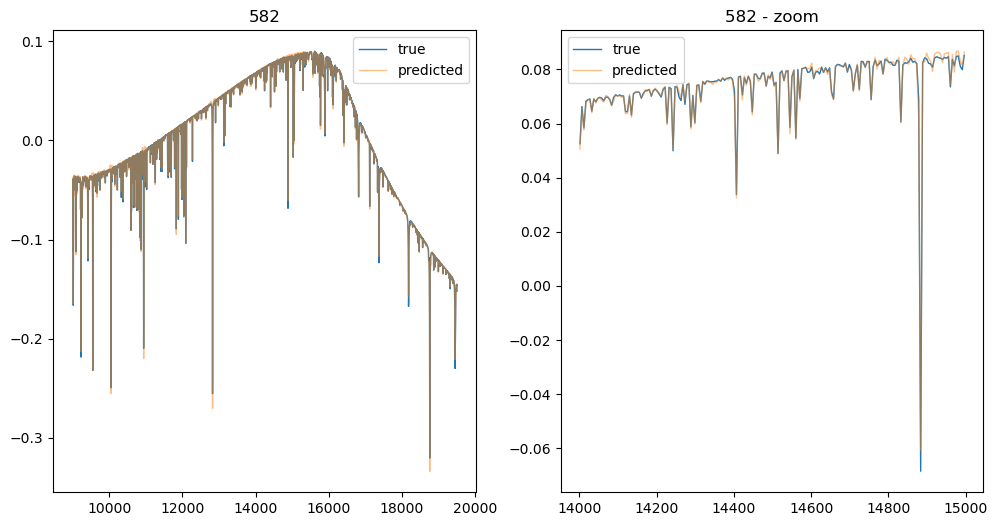

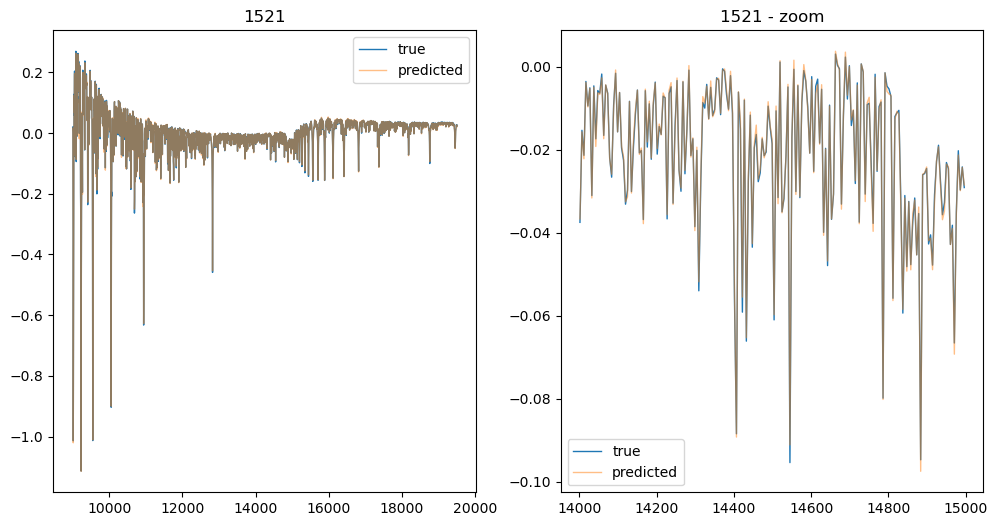

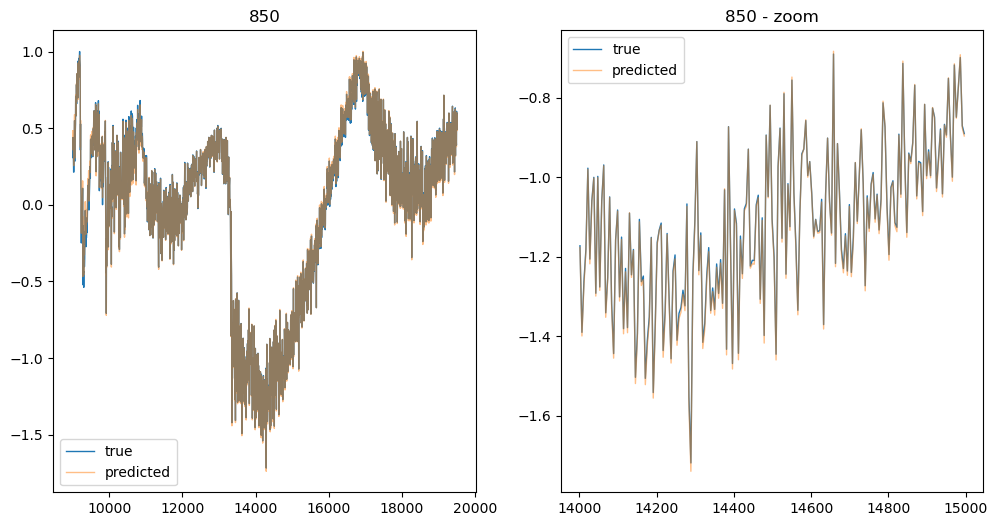

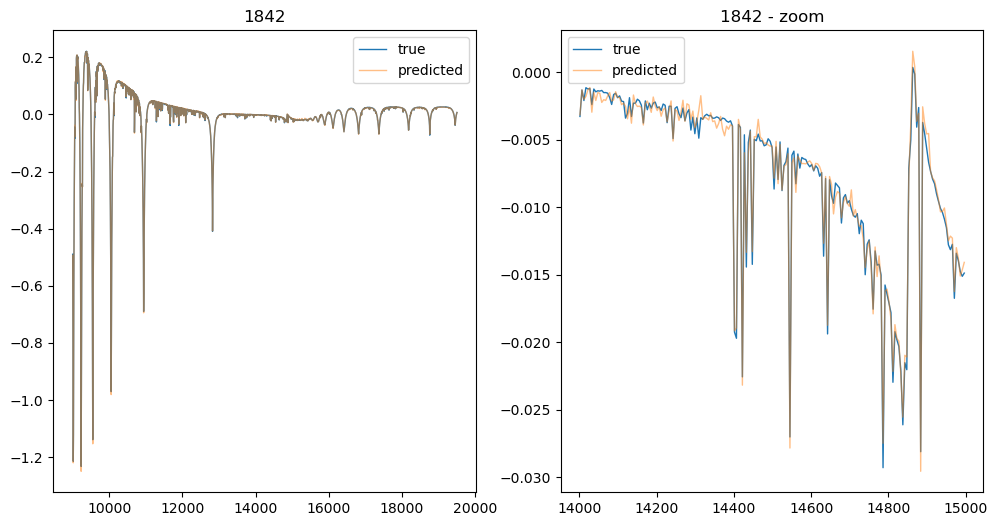

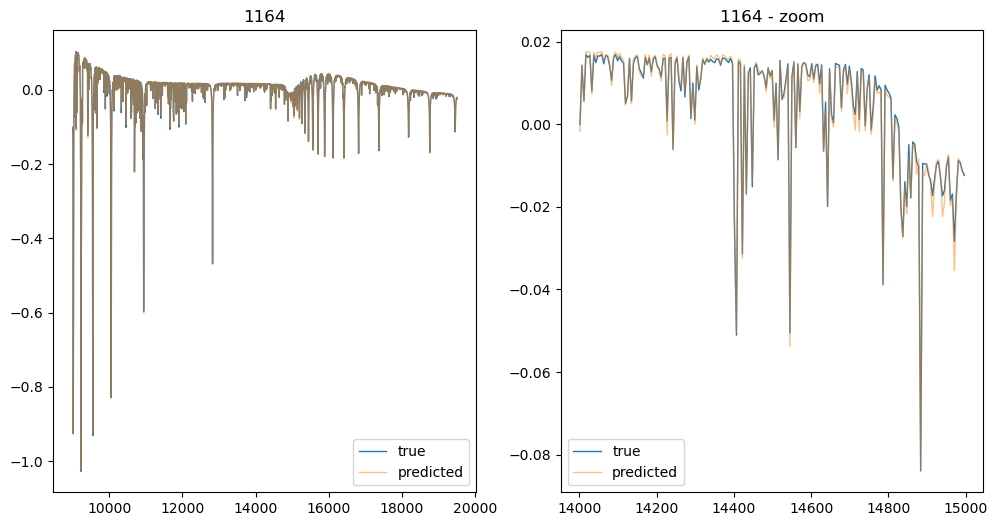

In [33]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 16]).to(device, tensor_dtype)

nperrestart = 3000
nrestarts = 3
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=aec_res_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=5e-4, 
                                            weight_decay=1e-5, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

This last one is looking pretty promising.

# Now try with standardized data

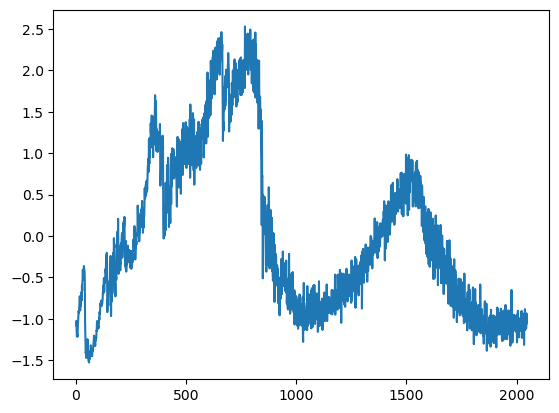

In [15]:
stdfluxes = ((fluxes.T - fluxes.mean(dim=1))/fluxes.std(dim=1)).T

plt.plot(stdfluxes[0])

aec_std_ds = TensorDataset(stdfluxes.to(device, tensor_dtype), stdfluxes.to(device, tensor_dtype))

  0%|          | 0/3000 [00:00<?, ?it/s]

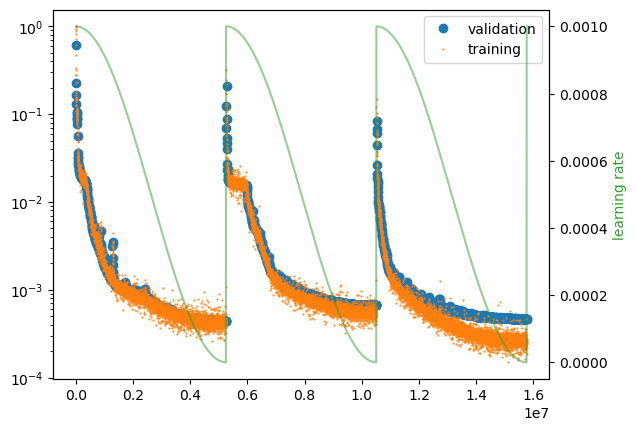

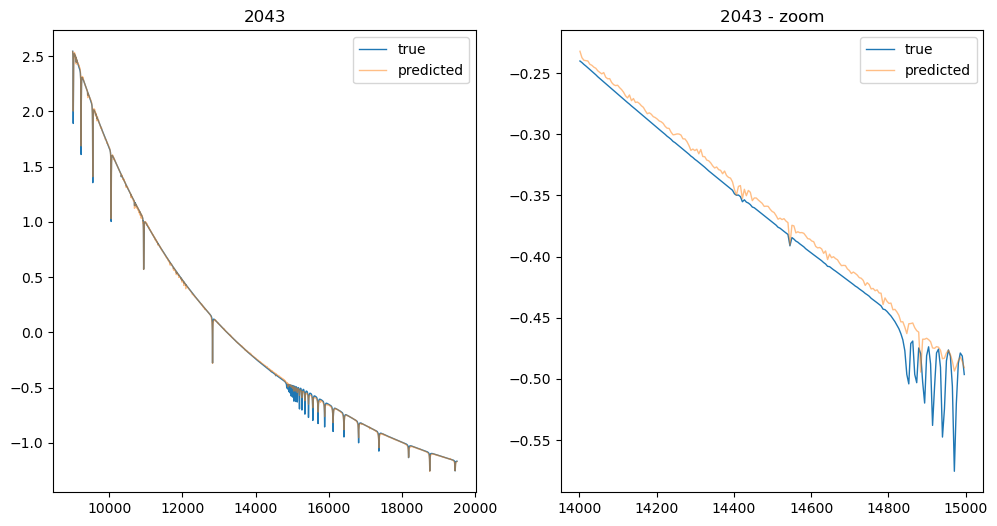

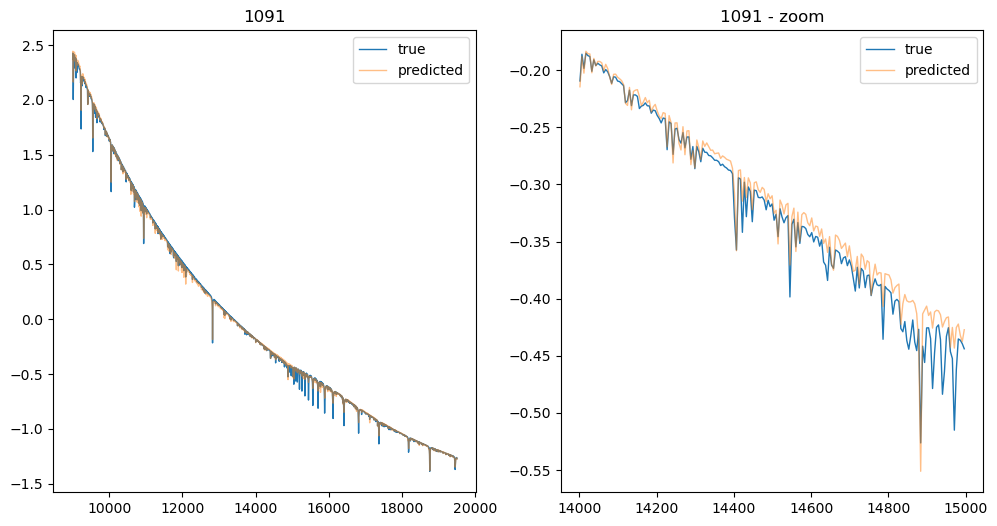

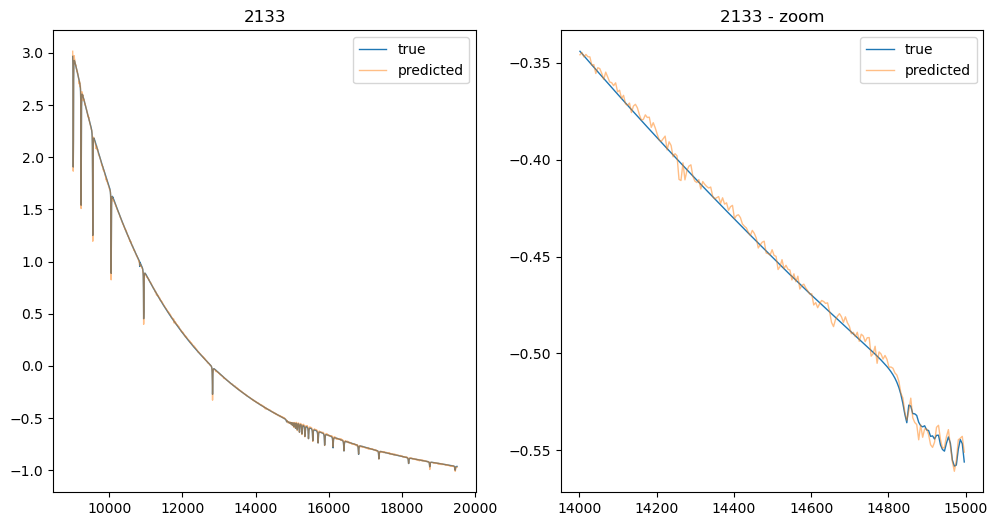

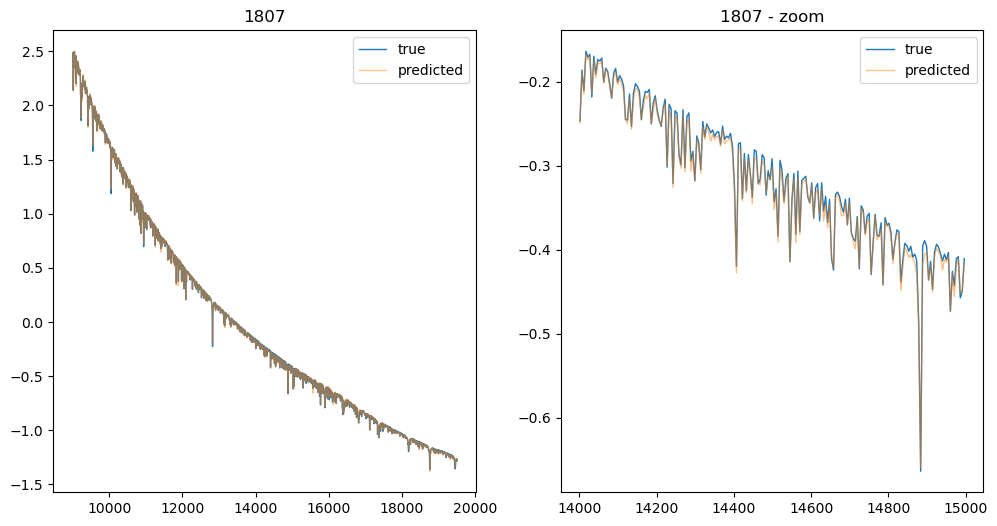

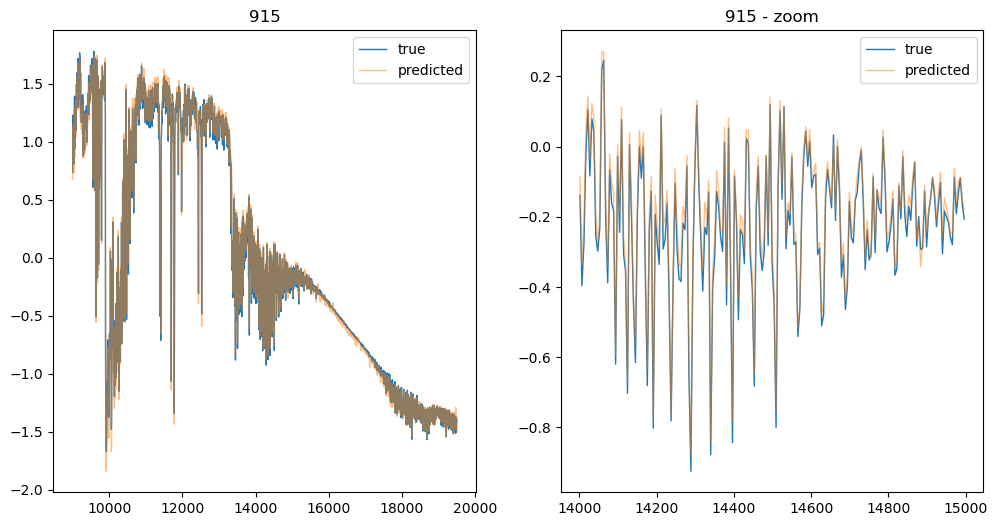

In [25]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 16]).to(device, tensor_dtype)

nperrestart = 1000
nrestarts = 3
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=aec_std_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=1e-3, 
                                            weight_decay=1e-5, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

Ok, this autoencoder approach seems to be doing OK. Now try some experiments with ways to re-normalize the data but in an easily deterministic way

First try fitting on the log of the flux with just a global mean/std offset

In [47]:
lfluxes = torch.log(fluxes)
lfm = lfluxes.mean()
lfs = lfluxes.std()
lfluxes_stded = (lfluxes - lfm)/lfs
def to_flux(y):
    return torch.exp(y*lfs + lfm)

(to_flux(lfluxes_stded) - fluxes)/fluxes

tensor([[ 9.4450e-16, -1.3964e-15,  1.4183e-15,  ...,  2.3107e-16,
          5.4016e-16, -6.2608e-16],
        [ 5.4293e-16, -1.3235e-16, -6.7132e-16,  ...,  1.4922e-15,
         -1.1769e-15,  1.1084e-15],
        [ 8.5419e-16, -1.1333e-15, -1.1640e-16,  ...,  1.0347e-15,
         -5.3577e-16,  1.7148e-15],
        ...,
        [ 1.4738e-15,  3.0729e-15, -1.4354e-15,  ..., -2.3292e-15,
         -1.4444e-15,  4.3024e-16],
        [-3.2959e-15, -3.4374e-15, -7.2288e-16,  ..., -1.9028e-15,
         -8.7124e-16,  1.0091e-15],
        [-2.1449e-15,  1.5487e-15,  1.4477e-15,  ..., -2.3442e-15,
          4.3603e-16, -2.8859e-16]], dtype=torch.float64)

In [48]:
aec_log_ds = TensorDataset(lfluxes_stded.to(device, tensor_dtype), lfluxes_stded.to(device, tensor_dtype))

  0%|          | 0/4000 [00:00<?, ?it/s]

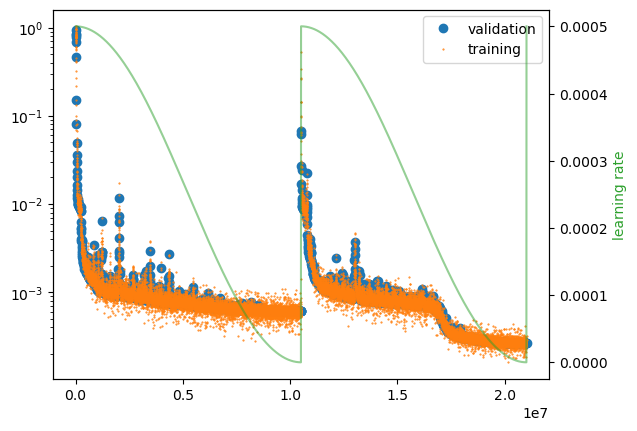

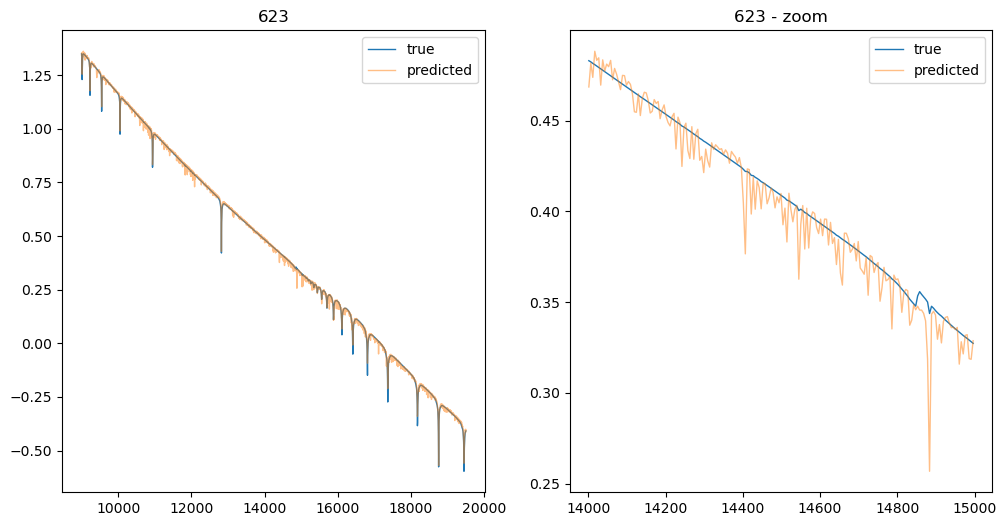

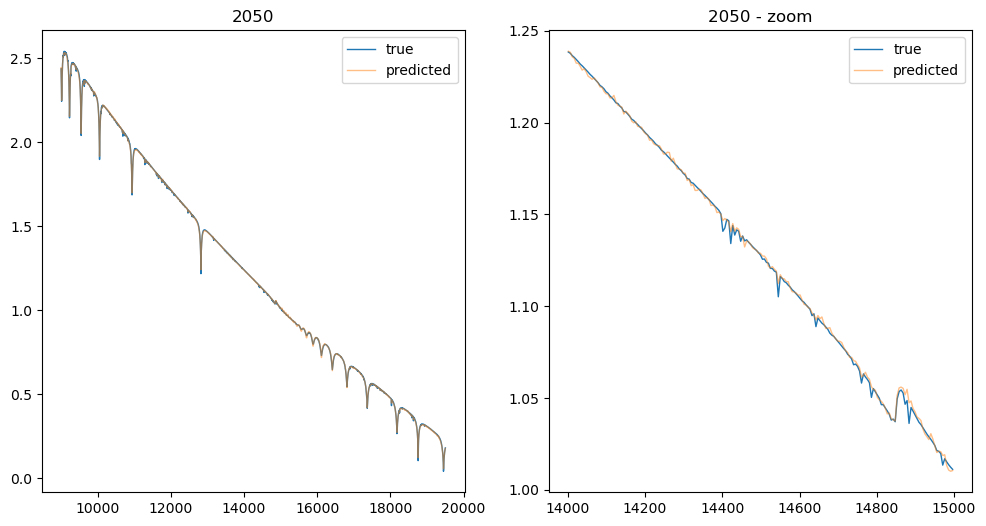

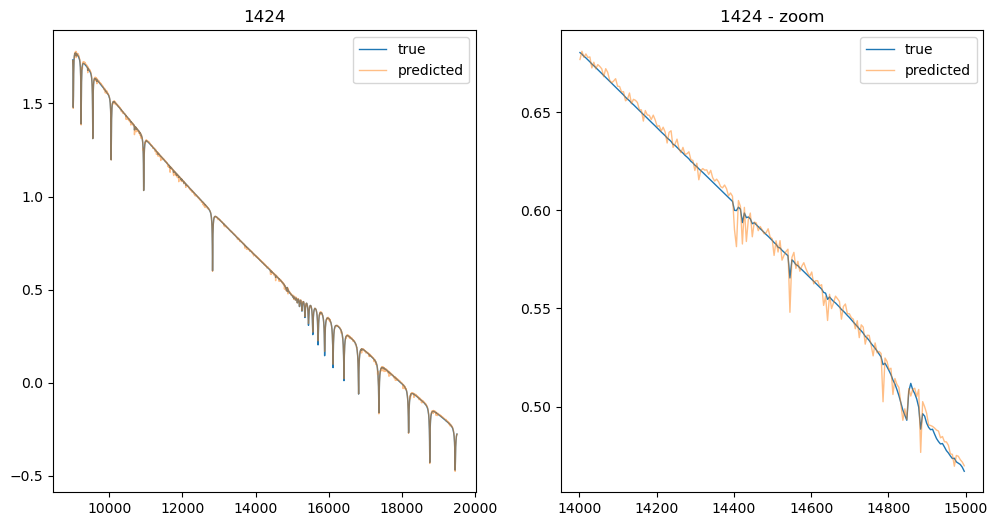

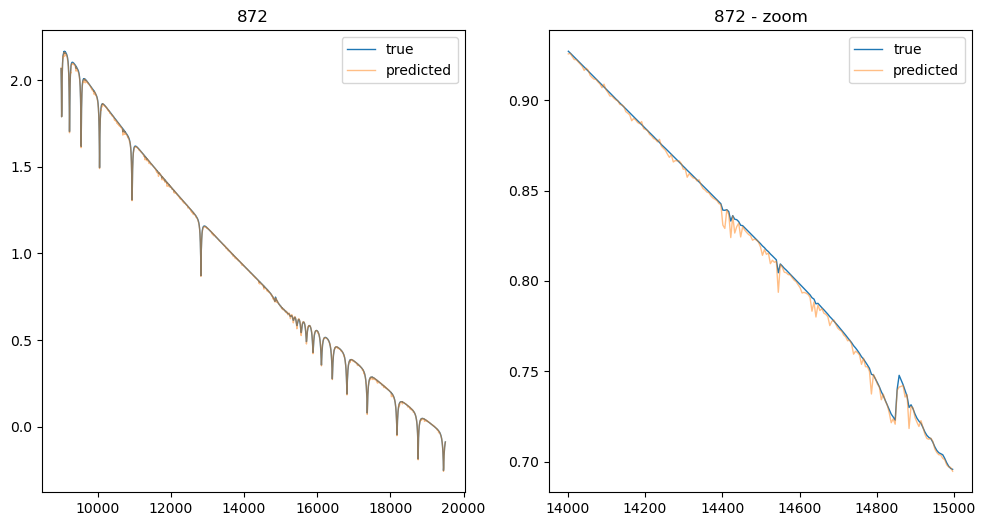

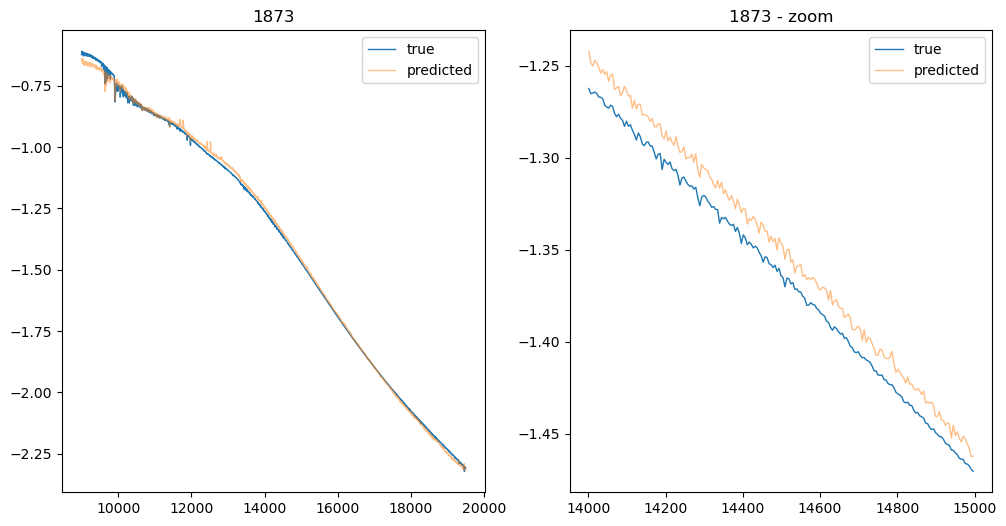

In [51]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 16]).to(device, tensor_dtype)

nperrestart = 2000
nrestarts = 2
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=aec_log_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=5e-4, 
                                            weight_decay=1e-5, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

De-logify

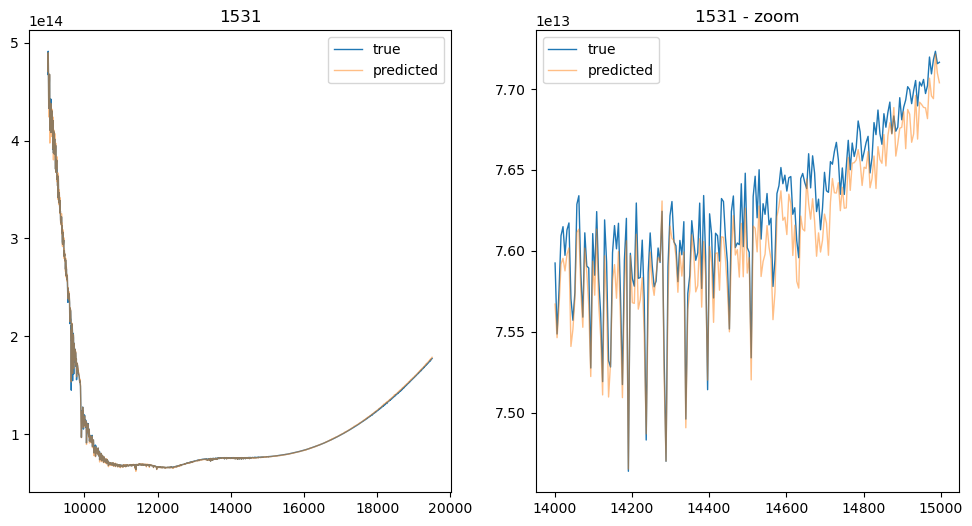

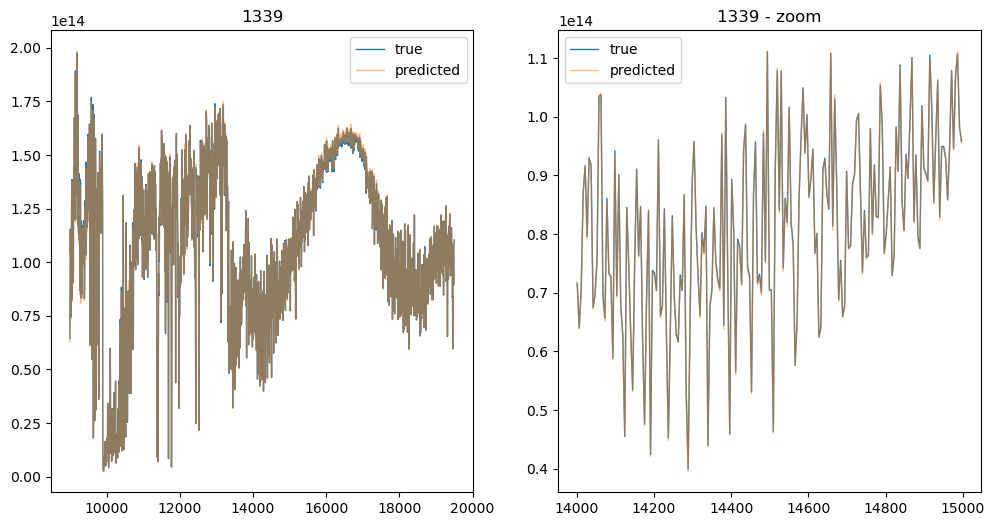

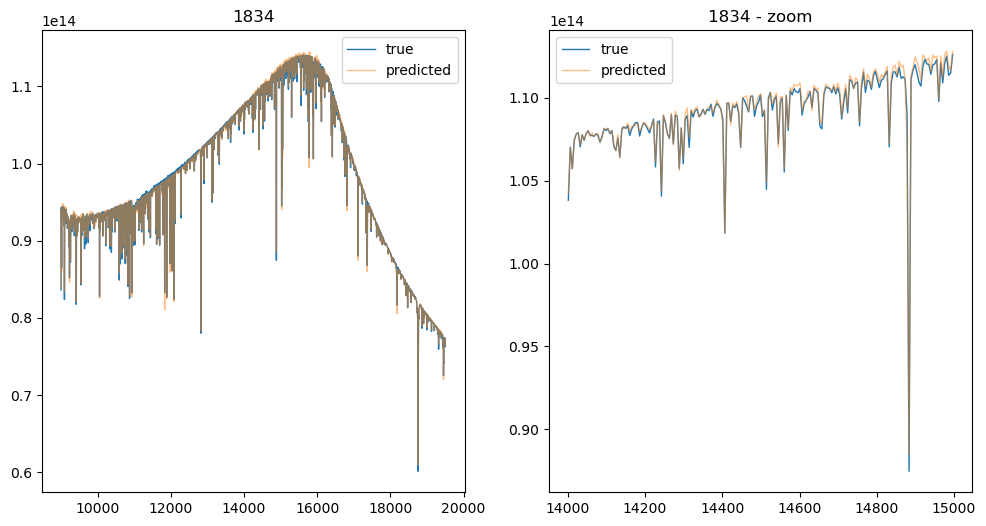

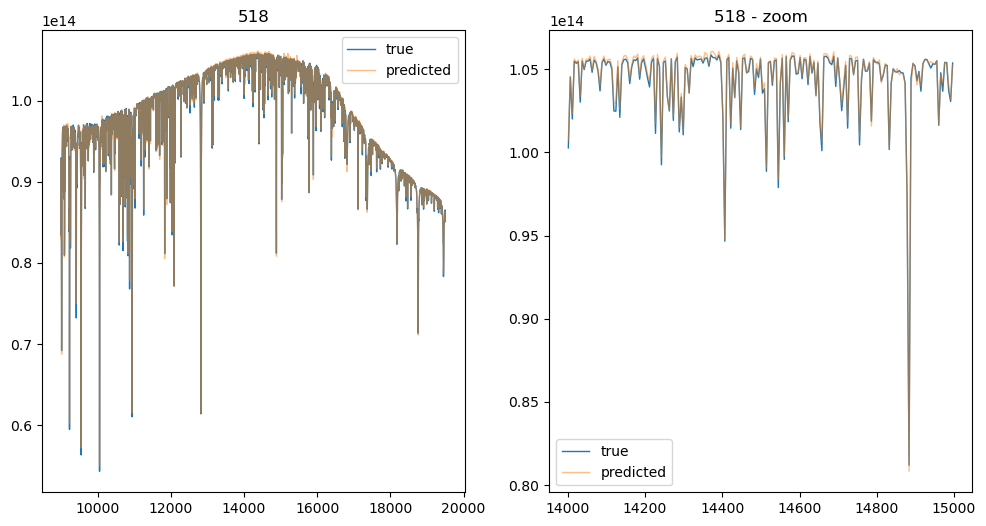

In [56]:
for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    Yi = to_flux(Yi)
    
    pred = model(Xi[None,...])[0].detach()
    pred = to_flux(pred)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

Seems a bit tougher to train.  Try exact same parameters  on the residual to compare

In [85]:
semires = []
for teffi, flux in zip(teff, fluxwunit):
    bb = modeling.models.BlackBody(temperature=teffi.item()*u.K, scale=1*flux.unit/u.sr)
    bbflux = bb(wl)*u.sr

    m = bbflux.mean()
    s = bbflux.std()

    rflux = (flux - m)/s
    rbbflux = (bbflux - m)/s
    semires.append(torch.Tensor((rflux - rbbflux).value))
semires = torch.stack(semires)

In [87]:
tri_res_ds = TensorDataset(semires.to(device, tensor_dtype), semires.to(device, tensor_dtype), infeatures.to(device, tensor_dtype))
next(iter(tri_res_ds))

(tensor([6.5569, 6.0734, 7.1948,  ..., 9.5147, 7.1418, 8.2491], device='cuda:0'),
 tensor([6.5569, 6.0734, 7.1948,  ..., 9.5147, 7.1418, 8.2491], device='cuda:0'),
 tensor([2.3000e+03, 0.0000e+00, 5.0000e-01], device='cuda:0'))

  0%|          | 0/5000 [00:00<?, ?it/s]

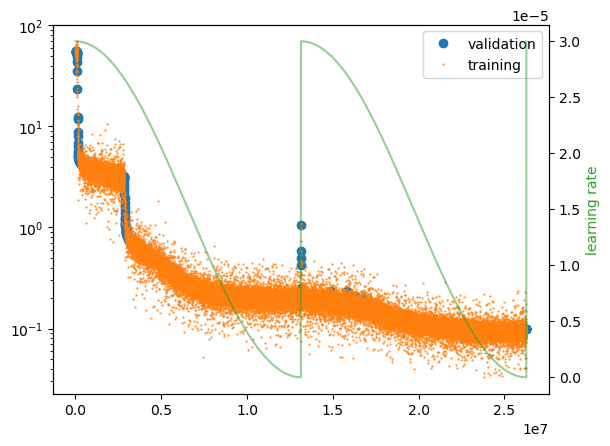

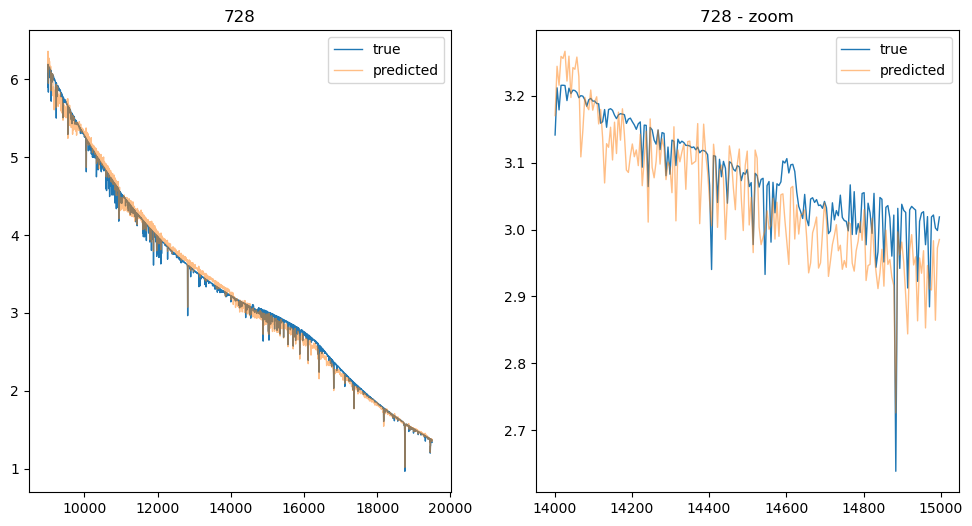

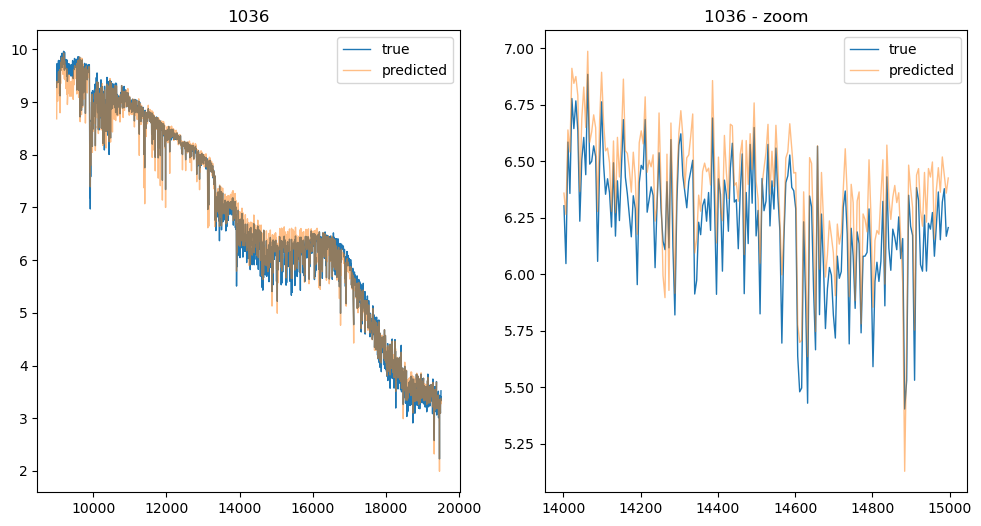

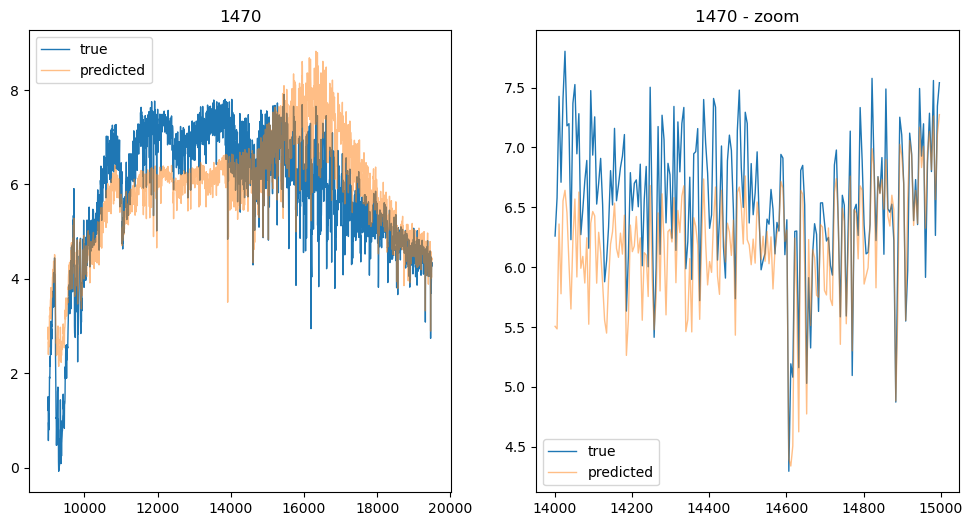

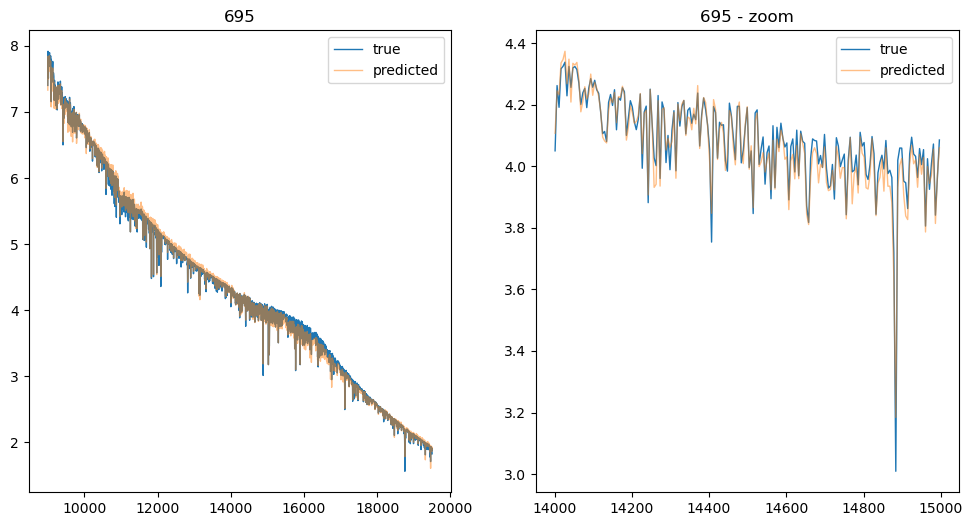

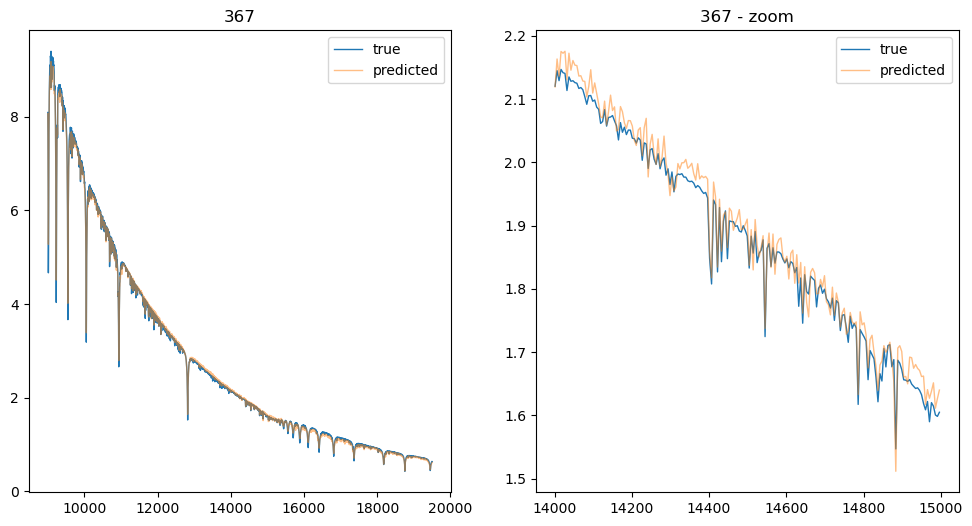

In [279]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 16, 8]).to(device, tensor_dtype)

nperrestart = 2500
nrestarts = 2
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=tri_res_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=3e-5, 
                                            weight_decay=1e-5, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors[:2]]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

Not awfu, lets just carry forward and make sure we can reconstruct the spectra

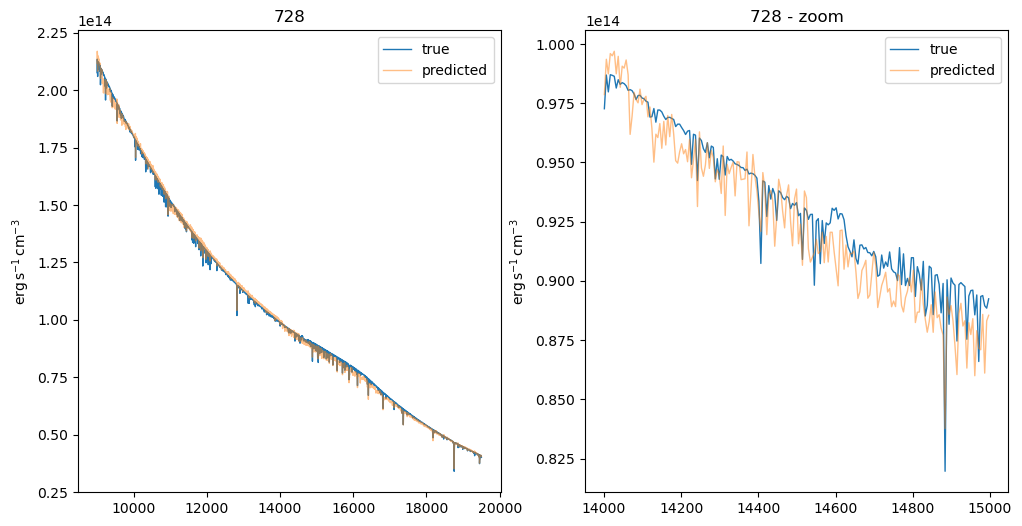

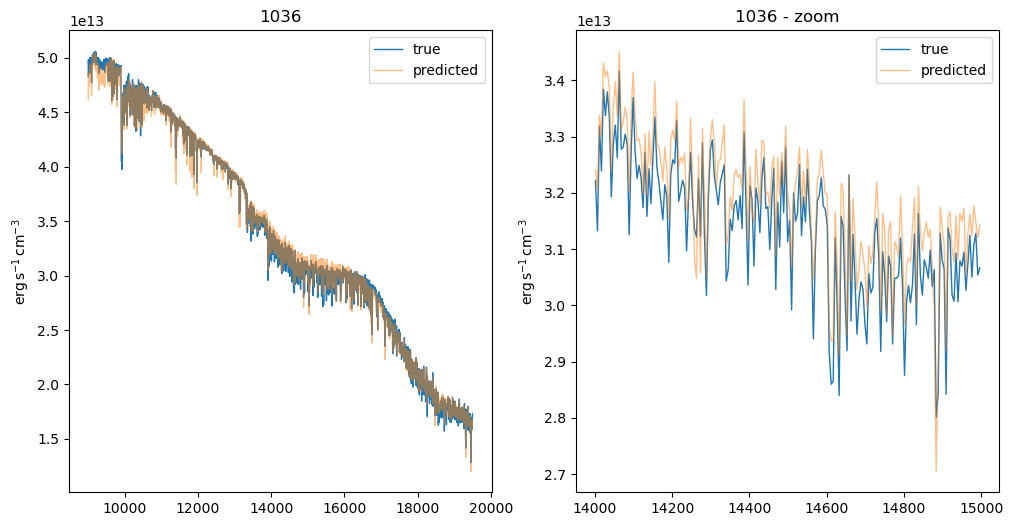

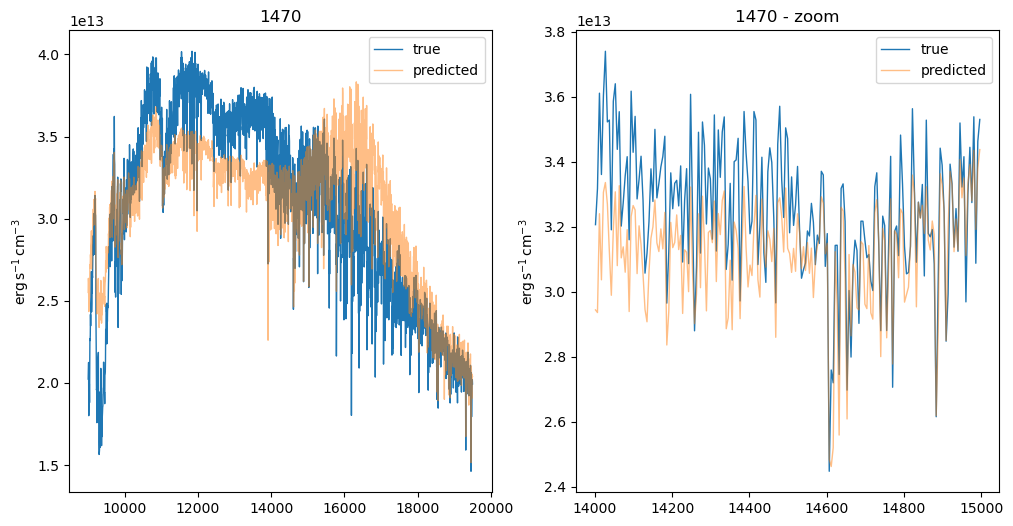

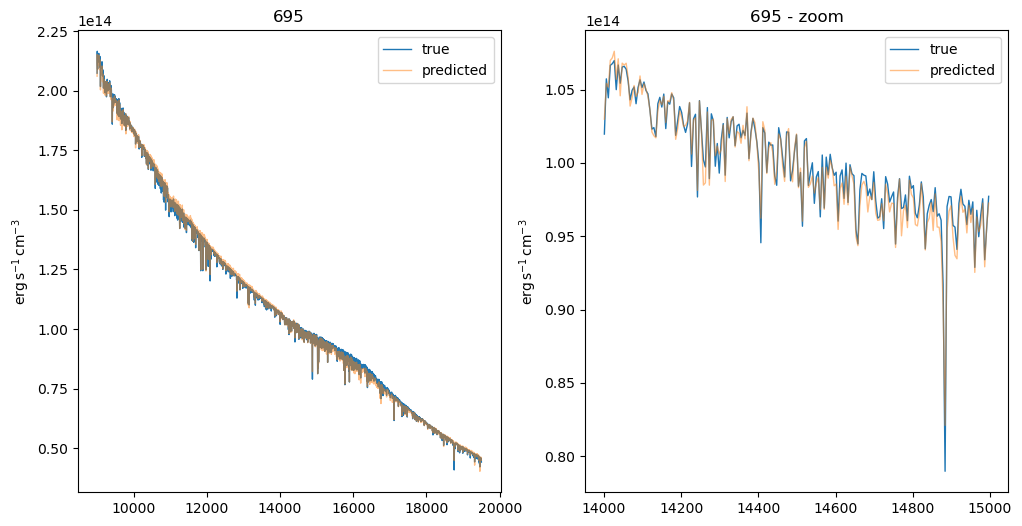

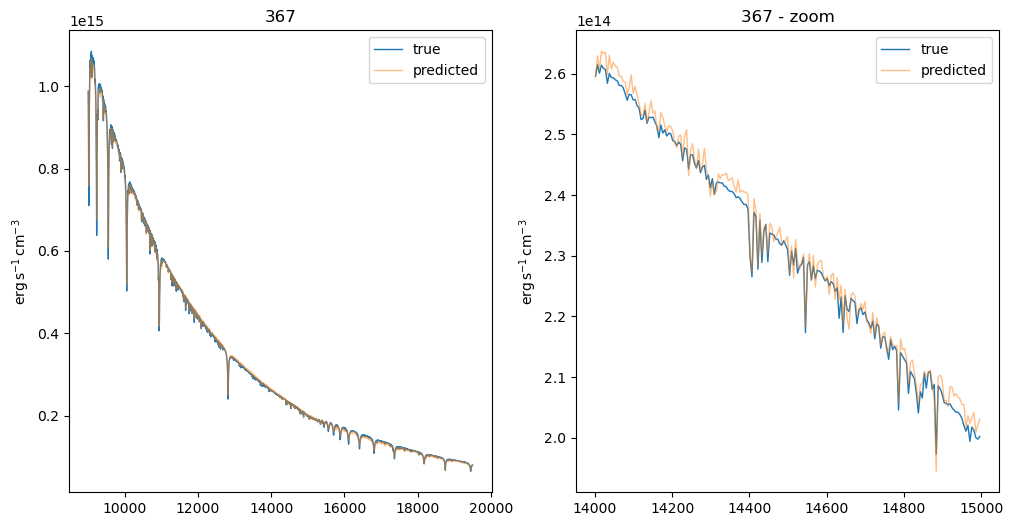

In [280]:
def de_res(y, teff):
    bb = modeling.models.BlackBody(temperature=teff.item()*u.K, scale=1*flux.unit/u.sr)
    bbflux = bb(wl)*u.sr

    m = bbflux.mean()
    s = bbflux.std()

    rbbflux = (bbflux - m)/s

    rflux = y + rbbflux

    return rflux*s + m

for valid_idx in valid_idxs:
    Xi, Yi, Fi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    teffi = Fi[0].cpu()
    
    pred = model(Xi[None,...])[0].detach()

    Yif = de_res(Yi.cpu(), teffi)
    predf = de_res(pred.cpu(), teffi)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yif, lw=1, label='true')
    ax1.plot(wl, predf, lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yif[msk], lw=1, label='true')
    ax2.plot(wl[msk], predf[msk], lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

Well that's not actually that terrible.  Lets varry on with trying to train the second half. as an MLP mapping the 3 in features to the latent space

# MLP training

In [281]:
aec = model

In [282]:
latent_data = aec.encoder(xy_res_ds.tensors[1]).detach()
in_to_latent_ds = TensorDataset(infeatures.to(device, tensor_dtype), latent_data)
next(iter(in_to_latent_ds))

(tensor([2.3000e+03, 0.0000e+00, 5.0000e-01], device='cuda:0'),
 tensor([ 6.4445e+00, -2.1565e-03, -2.2113e-05,  5.9232e+00, -2.4782e-06,
          3.8901e+00,  4.4516e-01,  2.5559e+00], device='cuda:0'))

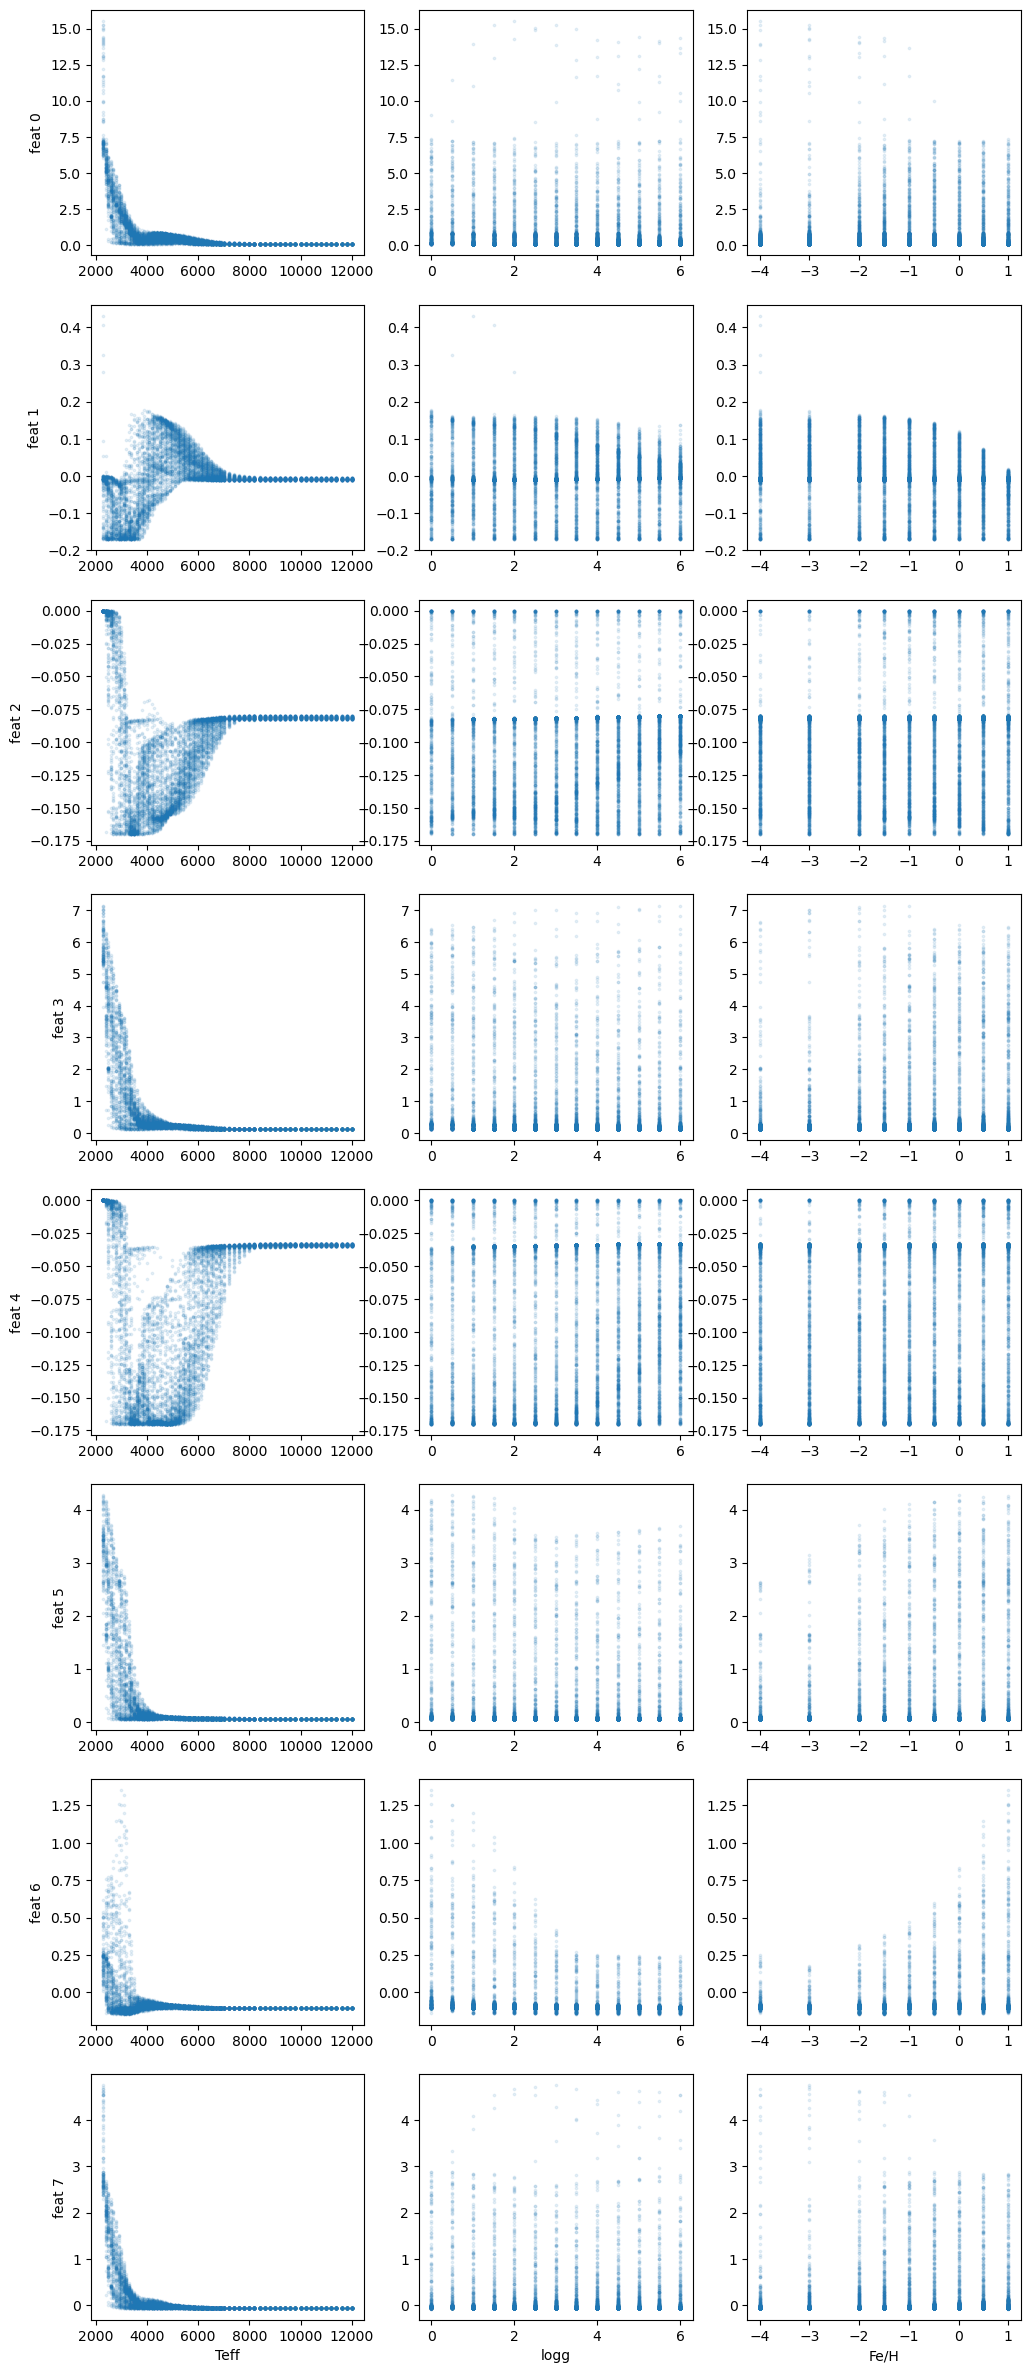

In [283]:
fig, axs = plt.subplots(latent_data.shape[-1], 3, figsize=(12, 30))

for i, latent in enumerate(latent_data.T):
    for j, infeature in enumerate(infeatures.T):
        axs[i, j].scatter(infeature.cpu(), latent.cpu(), s=3, alpha=.1)
        # if j==0:
        #     axs[i, j].semilogx()
axs[-1, 0].set_xlabel('Teff')
axs[-1, 1].set_xlabel('logg')
axs[-1, 2].set_xlabel('Fe/H')
for i, axset in enumerate(axs):
    axset[0].set_ylabel(f'feat {i}')


In [284]:
class MLP(nn.Module):
    def __init__(self, in_nfeatures, out_nfeatures, inner_layer_nneurons, batchnorm='firstonly', activation_cls=nn.GELU):
        super().__init__()

        prev_layern = in_nfeatures
        stack = []
        if batchnorm:
            stack.append(nn.BatchNorm1d(in_nfeatures))
            
        for nneurons in inner_layer_nneurons:
            stack.append(nn.Linear(prev_layern, nneurons))
            if batchnorm and batchnorm != 'firstonly':
                stack.append(nn.BatchNorm1d(nneurons))
            stack.append(activation_cls())
            prev_layern = nneurons
        stack.append(nn.Linear(prev_layern, out_nfeatures))
        
        self.mlp_stack = nn.Sequential(*stack)

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def in_nfeatures(self):
        return self.mlp_stack[0].num_features
        
    @property
    def out_nfeatures(self):
        return self.mlp_stack[-1].out_features

    def forward(self, x):
        return self.mlp_stack(x)

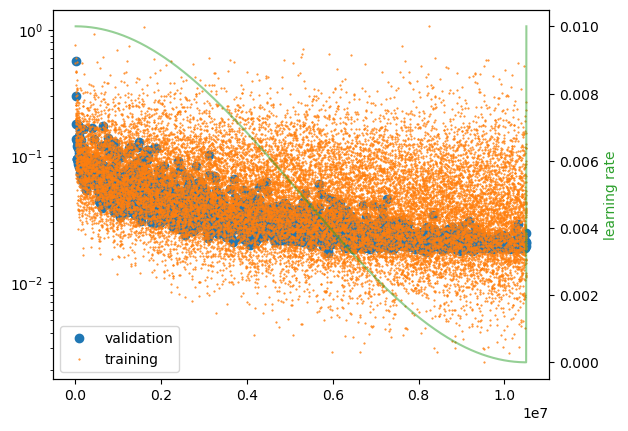

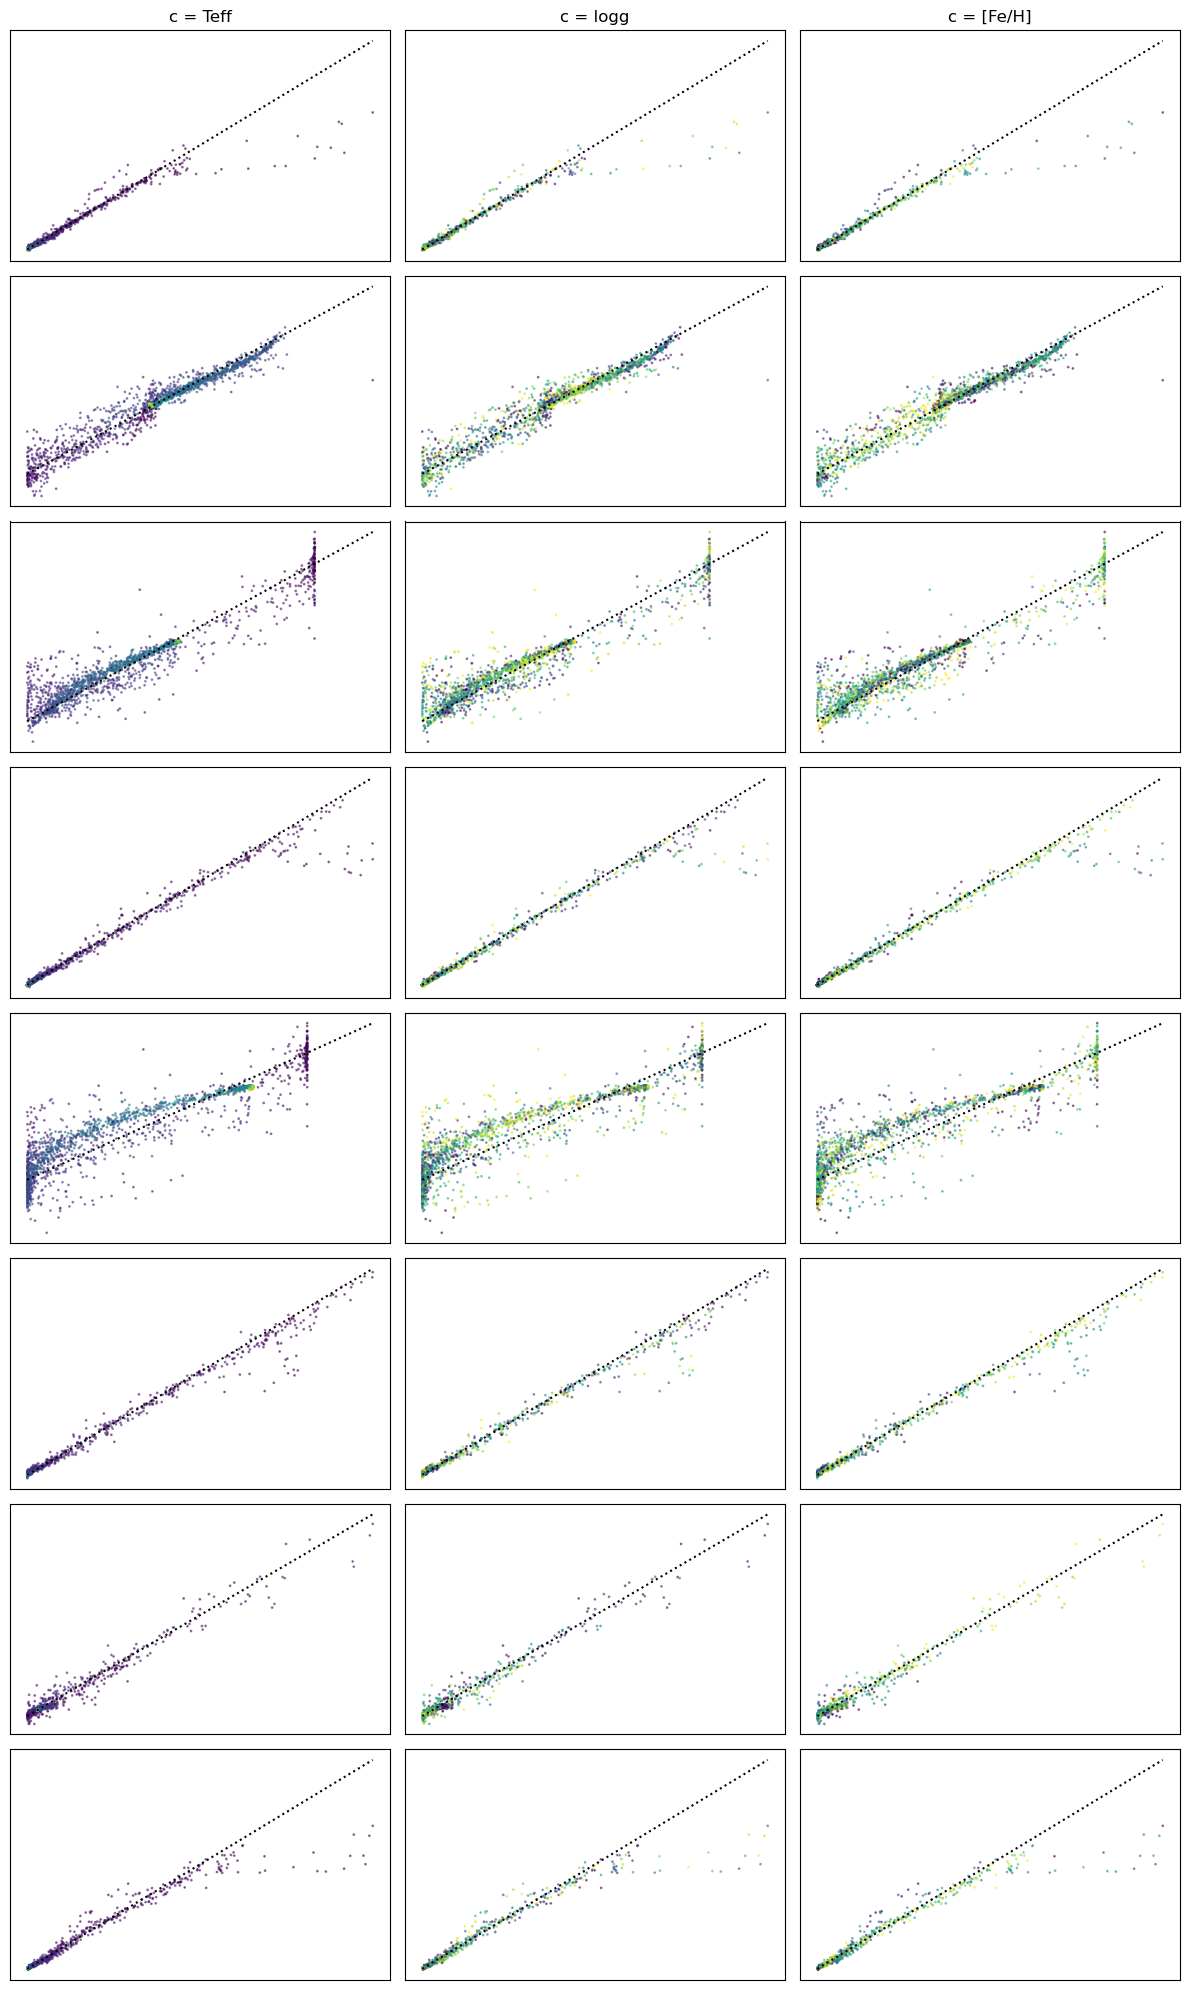

In [286]:
model = mlp = MLP(infeatures.shape[-1], latent_data.shape[-1], [16, 1024, 32]).to(device)

nperrestart = 2000
nrestarts = 1
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=in_to_latent_ds, 
                                            nepochs=nepochs, 
                                            batch_size=512, 
                                            lr=1e-2, 
                                            weight_decay=1e-3, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split

vin, vlatent = [t[valid_data.indices] for t in valid_data.dataset.tensors]
pred_latent = model(vin).detach()

fig, axs = plt.subplots(latent_data.shape[-1], 3, figsize=(12, 20))
for i, axrow in enumerate(axs):
    for j, (inf, ax) in enumerate(zip(vin.T, axrow)):
        # residuals
        #ax.scatter(vlatent[:, i].cpu(), (vlatent - pred_latent).cpu()[:, i], s=1, alpha=.5, c=inf.cpu())
        #ax.axhline(0, c='k', ls=':')
        ax.scatter(vlatent[:, i].cpu(), pred_latent[:, i].cpu(), s=1, alpha=.5, c=inf.cpu())
        mx = max(vlatent[:, i].max(), pred_latent[:, i].max()).item()
        mi = max(vlatent[:, i].min(), pred_latent[:, i].min()).item()
        ax.plot([mi, mx], [mi, mx], c='k', ls=':')
        if i == 0:
            if j == 0:
                ax.set_title('c = Teff')
            elif j == 1:
                ax.set_title('c = logg')
            elif j == 2:
                ax.set_title('c = [Fe/H]')
        ax.set_xticks([])
        ax.set_yticks([])
fig.tight_layout()

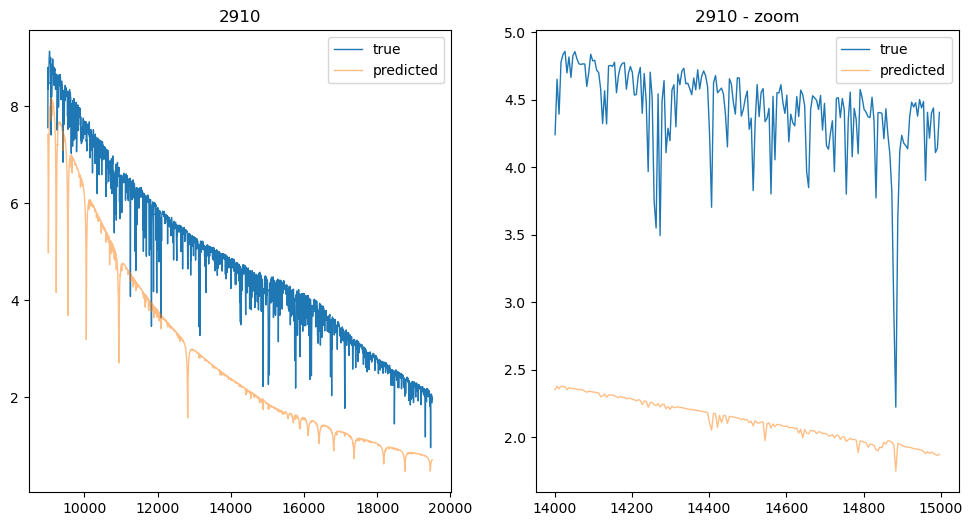

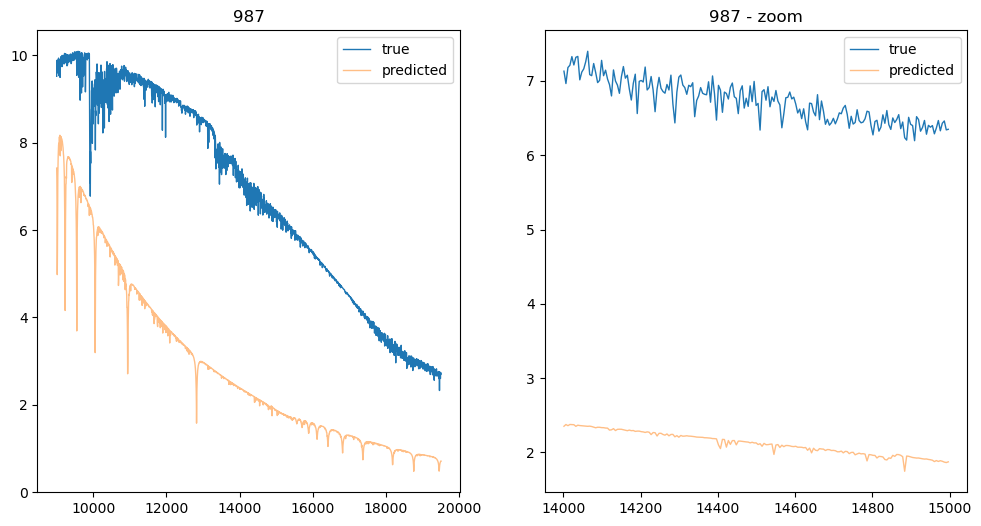

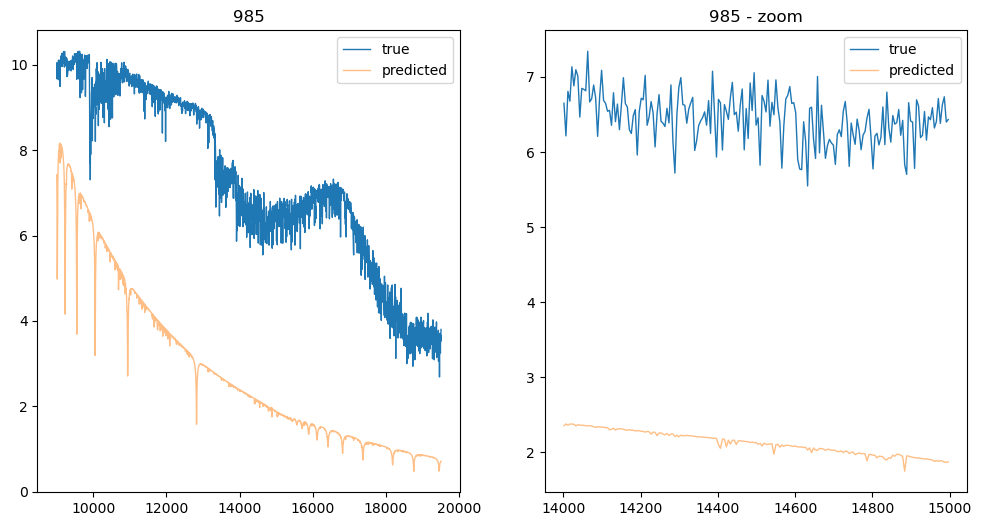

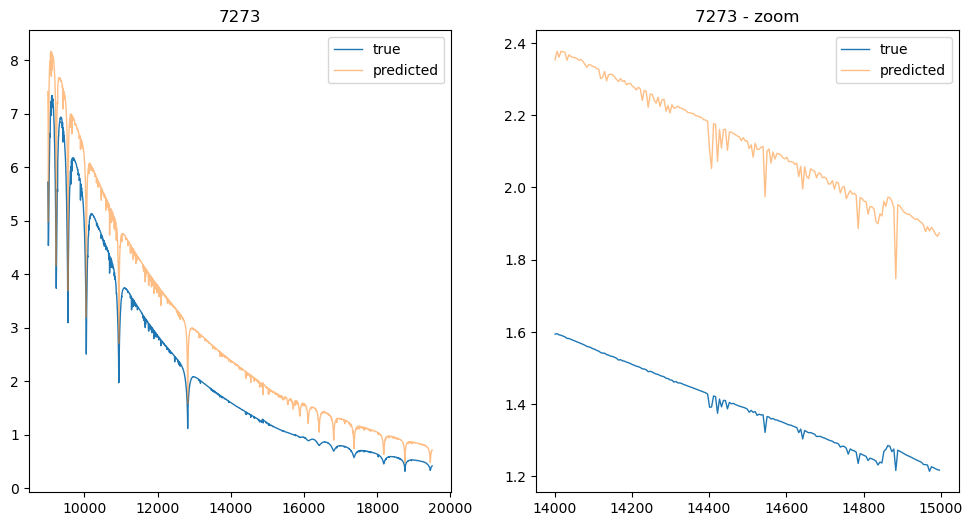

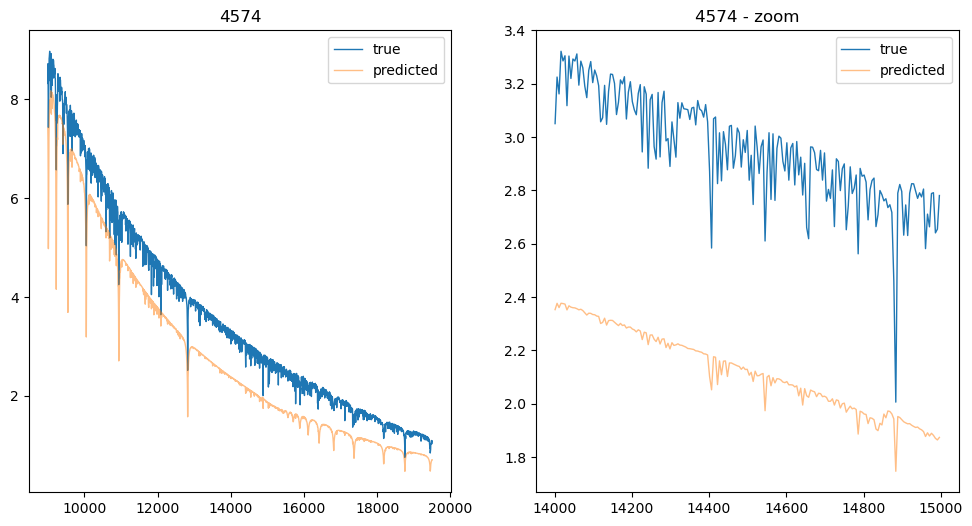

In [287]:
valid_idxs = np.array(valid_data.indices)[np.random.randint(len(valid_data), size=5)]

for valid_idx in valid_idxs:
    infi = tri_res_ds.tensors[-1][valid_idx]
    speci = tri_res_ds.tensors[0][valid_idx]
    
    # this is just checking the autoencoder
    #pred_spec = aec.decoder(aec.encoder(speci[None,...]))[0].detach()
    #pred_spec = aec(speci[None,...])[0].detach()

    #pred_spec = aec.decoder(mlp(infi[None,...]))[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, speci.cpu(), lw=1, label='true')
    ax1.plot(wl, pred_spec.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], speci[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred_spec[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

Well apparently these slopes are important...

# Replicate Gebran 24 architecture

  0%|          | 0/2000 [00:00<?, ?it/s]

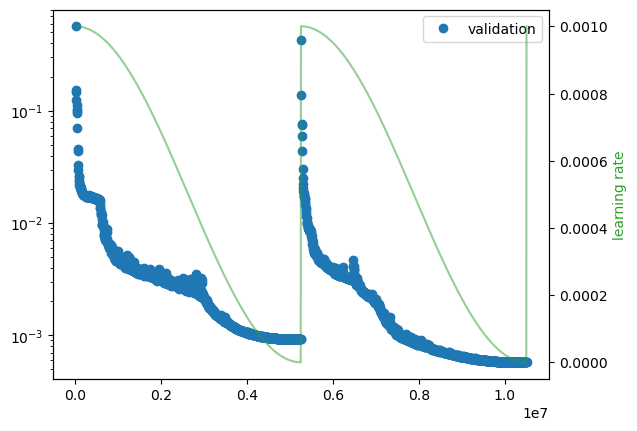

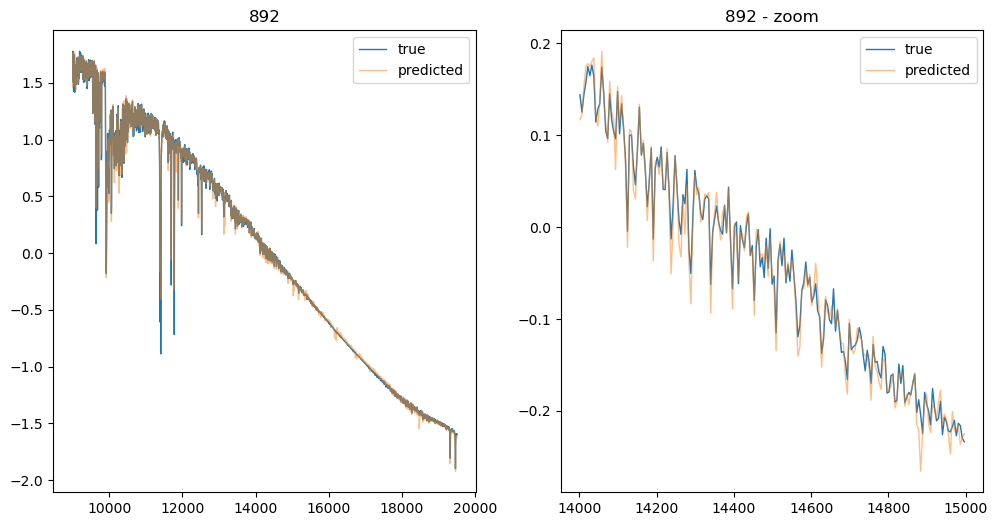

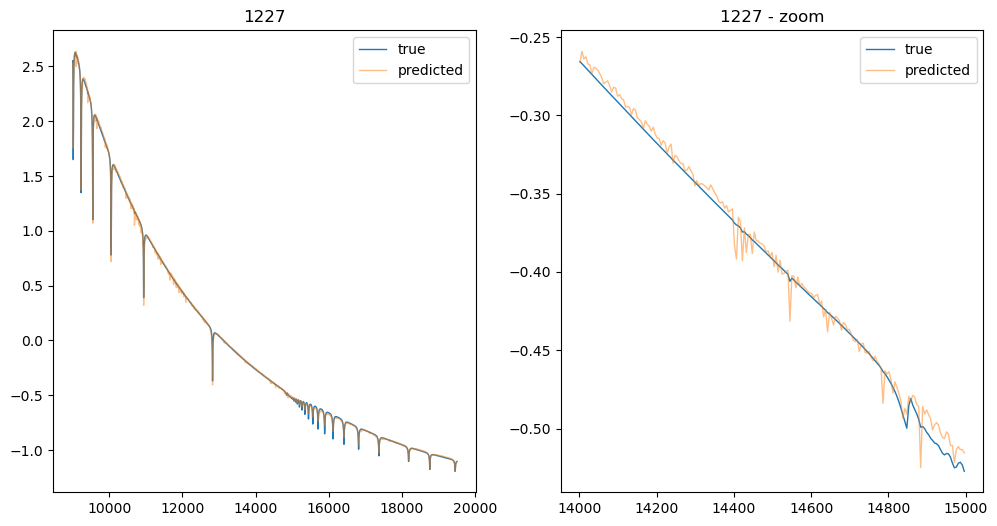

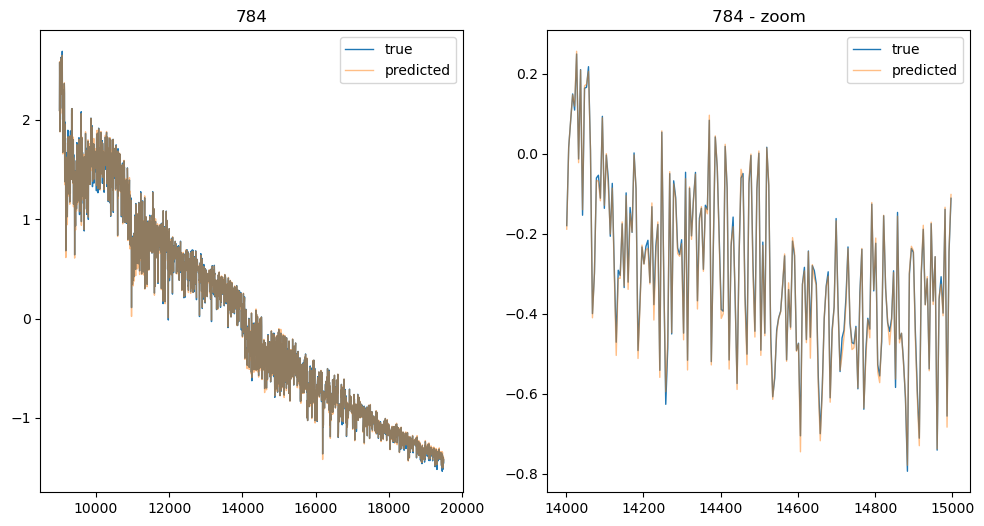

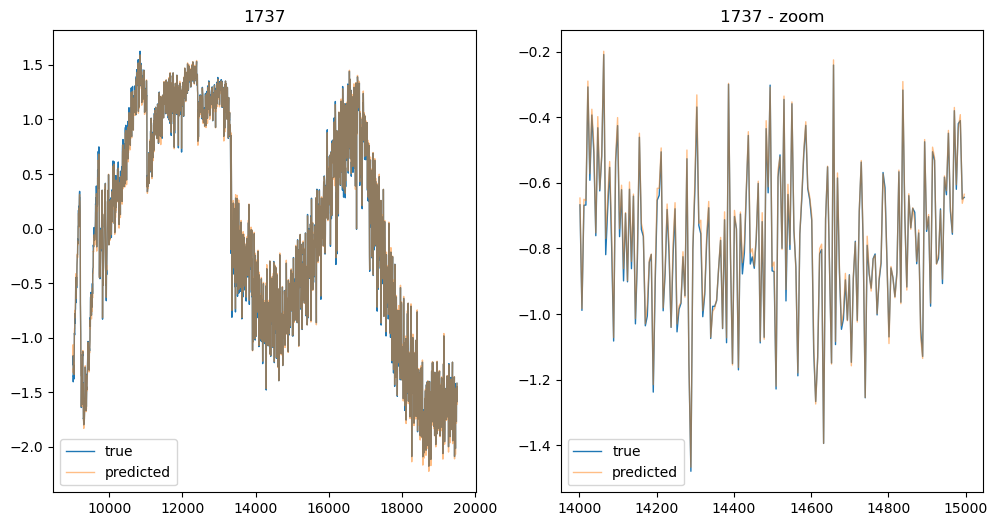

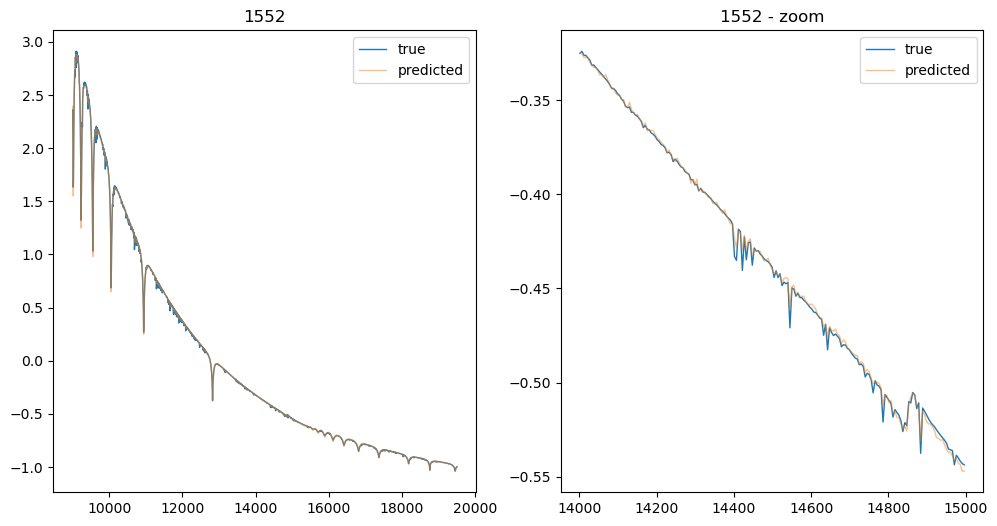

In [16]:
model = Autoencoder(fluxes.shape[-1], [1024, 512, 256, 128, 64, 32, 10], nn.ReLU).to(device, tensor_dtype)

nperrestart = 1000
nrestarts = 2
nepochs = nperrestart*nrestarts
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, T_0=nperrestart)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=aec_std_ds, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=1e-3, 
                                            weight_decay=0, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')

plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')